In [1]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from pylab import * # I know this is convienent but it's better to be explicit
from viewser.operations import fetch
from viewser import Queryset, Column
from ingester3.extensions import * # I know this is convienent but it's better to be explicit
import glob
import os
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.table import Table
import matplotlib.font_manager as fm


#some extra functions for some of the later demonstration
import pandas as pd
import numpy as np
import subprocess
#Define QuerySet
pd.set_option('display.max_rows', None)

In [2]:
# Check the version of the views packages installed
!pip freeze | grep views

views-partitioning==3.0.1
views-schema==2.3.0
views-storage==1.1.6
views_forecasts==0.5.4
views_runs==1.14.2
viewser==5.14.0


In [3]:
def set_paths():
    
    """
    Sets the paths to the data, reports, and plots, ensuring consistency across all machines.
    This function checks if the paths exist and raises an error if they don't.
    """
    # Set the path to the root of the repo
    root_path = Path.cwd().parents[1]

    # Check if the root path exists
    if root_path.name != 'VIEWS_FAO_index':
        raise ValueError('The root path does not exist or is incorrect')
    
    else:
        print(f"Root path exists")

    # Define relative paths in a dictionary
    paths = {
        'raw_data': root_path / 'data/raw_viewser',
        'processed_data': root_path / 'data/processed',
        'generated_data': root_path / 'data/generated',
        'aggregation_tables': root_path / 'notebooks/Benz_experiments/Aggregation_Key_Tables', # move later
        'timeline_tables': root_path / 'notebooks/Benz_experiments/Tables_For_Timeline_Maps',# move later
        'report_inf': root_path / 'notebooks/Benz_experiments/Report_Checks/Report_inf_values',# move later
        'agg_completeness': root_path / 'notebooks/Benz_experiments/Report_Checks/Aggregation_completeness',# move later
        'compare_countries': root_path / 'notebooks/Benz_experiments/Country_Comparisons',# move later
    }

    # Make a list of paths that does not exist
    non_existing_paths = [str(path) for path, pobj in paths.items() if not pobj.exists()]

    # Raise an error if any of the paths do not exist
    if non_existing_paths:
        raise ValueError(f'The following paths do not exist: {", ".join(non_existing_paths)}')
    else:
        print("All paths exist.")

    return paths.values()


In [4]:
def get_querysets():

    """
    Returns the base querysets for the country and priogrid month data.
    """

    # Define the PRIO grid month queryset
    queryset_base_PG = (Queryset("Benz_PG_CF", "priogrid_month")

        .with_column(Column("country_name", from_table = "country", from_column = "name")
            .transform.missing.replace_na()
            )

        .with_column(Column("country_id", from_table="country", from_column='id'))

        #column with wkt to review 
        .with_column(Column("C_start_year", from_table="country", from_column='gwsyear'))

        .with_column(Column("C_end_year", from_table="country", from_column='gweyear'))

        .with_column(Column("year_id", from_table = "country_year", from_column = "year_id")
            )

        # target variable
        .with_column(Column("ged_sb", from_table = "ged2_pgm", from_column = "ged_sb_best_sum_nokgi")
            .transform.missing.replace_na()
            #.transform.ops.ln()
            )

        .with_column(Column("ged_ns", from_table = "ged2_pgm", from_column = "ged_ns_best_sum_nokgi")
            .transform.missing.replace_na()
            #.transform.ops.ln()
            )

        .with_column(Column("ged_os", from_table = "ged2_pgm", from_column = "ged_os_best_sum_nokgi")
            .transform.missing.replace_na()
            #.transform.ops.ln()
            )

        .with_column(Column("sb_count", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi")
            .transform.missing.replace_na()

            )

        .with_column(Column("ns_count", from_table = "ged2_pgm", from_column = "ged_ns_best_count_nokgi")
            .transform.missing.replace_na()

            )

        .with_column(Column("os_count", from_table = "ged2_pgm", from_column = "ged_os_best_count_nokgi")
            .transform.missing.replace_na()

            )
        .with_column(Column("pop_gpw_sum", from_table="priogrid_year", from_column="pop_gpw_sum")

            )
            )

    # Define the country month queryset
    queryset_base_CM = (Queryset("Benz_PG_CF", "country_month")

        .with_column(Column("country_name", from_table = "country", from_column = "name")
            .transform.missing.replace_na()
            )

        .with_column(Column("year_id", from_table = "country_year", from_column = "year_id")
            )

        # target variable
        .with_column(Column("ged_sb", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
            .transform.missing.replace_na()
            #.transform.ops.ln()
            )

        .with_column(Column("ged_ns", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
            .transform.missing.replace_na()
            #.transform.ops.ln()
            )

        .with_column(Column("ged_os", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
            .transform.missing.replace_na()
            #.transform.ops.ln()
            )

        .with_column(Column("sb_count", from_table = "ged2_cm", from_column = "ged_sb_best_count_nokgi")
            .transform.missing.replace_na()

            )

        .with_column(Column("ns_count", from_table = "ged2_cm", from_column = "ged_ns_best_count_nokgi")
            .transform.missing.replace_na()

            )

        .with_column(Column("os_count", from_table = "ged2_cm", from_column = "ged_os_best_count_nokgi")
            .transform.missing.replace_na()

            )
        .with_column(Column("pop_gpw_sum", from_table="wdi_cy", from_column="wdi_sp_pop_totl")

            )
            )

    return queryset_base_PG, queryset_base_CM

In [5]:
def get_data(raw_data_path):

    """
    Fetches the data from the querysets and returns it as dataframes.
    """

    # Check if the data is already fetched
    if os.path.exists(f'{raw_data_path}/data_pg.csv') and os.path.exists(f'{raw_data_path}/data_cm.csv'):

        print('Data already fetched')

        df_pg = pd.read_csv(f'{raw_data_path}/data_pg.csv')
        df_cm = pd.read_csv(f'{raw_data_path}/data_cm.csv')

        print('Data read from csv to memory')

        return df_pg, df_cm

    else:

        print('Data not fetched yet - fetching data from querysets')

        # Get the base querysets
        queryset_base_PG, queryset_base_CM = get_querysets()

        # Fetch the data
        df_pg = queryset_base_PG.publish().fetch()
        df_pg = df_pg.reset_index()

        df_cm = queryset_base_CM.publish().fetch()
        df_cm = df_cm.reset_index()

        print(f'Data fetched - saving to csv in {raw_data_path}')

        # Save the data to csv 
        df_pg.to_csv(f'{raw_data_path}/data_pg.csv', index=False)
        df_cm.to_csv(f'{raw_data_path}/data_cm.csv', index=False)

        print(f'Data saved to csv in {raw_data_path}')

    return df_pg, df_cm

In [6]:
raw_data_path, processed_data_path, generated_data_path, aggregation_tables_dir, Timeline_tables_dir, report_inf, agg_completeness, compare_countries = set_paths()
query_base_PG, query_base_CM = get_querysets()
df_pg, df_cm = get_data(raw_data_path)

Root path exists
All paths exist.
Data already fetched
Data read from csv to memory


# This toolbox considers 3 primary paramters

- **Parameter 1:** Is this analysis employing PGM or CM data?<br><br>
- **Parameter 2:** What level of SPACE aggregation is the user interested in?<br>
    - *Options include -- Original PrioGRid aggregation 1x1 or courser aggregations 2x2, 3x3, 4x4, 5x5, 6x6, 8x8, 9x9, and 10x10*<br><br>
- **Parameter 3:** What level of TIME aggregation is the user interested in?<br><br>
    - *Options include -- Original PrioGRid monthly resolution and annual*<br>
    - Note that within this time parameter, the range of available data is fixed between 1989-2022.<br><br>
- **Parameter 4:** Define the processing extent to apply space and time factors<br><br>
- **Parameter 5:** Establish what statistics to generate for the Unit of Analysis and designated Area of Responsibility'<br><br>

In [7]:
def PGM_preprocess(table):
    # Make a copy of the DataFrame to ensure we are not modifying a slice.
    table = table.copy()

    # Replace NA Population values with 0
    table['pop_gpw_sum'] = table['pop_gpw_sum'].fillna(0)

    # Calculate Fatalities Sum directly without intermediate modification warnings
    table['Fatalities_Sum'] = table['ged_sb'].fillna(0) + table['ged_ns'].fillna(0) + table['ged_os'].fillna(0)

    # Calculate PerCapitaFatalities, handling division by zero or NaN values
    table['PerCapitaFatalities'] = table['Fatalities_Sum'] / table['pop_gpw_sum']
    table['PerCapitaFatalities'] = table['PerCapitaFatalities'].fillna(0)

    # Drop specified columns
    table = table.drop(['ged_sb', 'ged_ns', 'ged_os', 'sb_count', 'ns_count', 'os_count'], axis=1)

    return table


In [8]:
def report_infinity_values(base_table,CM__or__PG, resolution=0):

    if resolution == 0:
        res = '_'
    else:
        res = resolution

    CM__or__PGstr = CM__or__PG+'_'

    base_table['PerCapitaFatalities'] = base_table['PerCapitaFatalities'].replace([np.inf, -np.inf], np.nan)
    Anamoly = base_table[base_table['PerCapitaFatalities'].isna()]
    #Anamoly.to_csv(f'/Users/gbenz/Documents/Food Security and Conflict/{CM__or__PGstr}{res}Fatality_NoPop.csv')
    Anamoly.to_csv(f'{report_inf}{CM__or__PGstr}{res}Fatality_NoPop.csv')

    base_table['PerCapitaFatalities'] = base_table['PerCapitaFatalities'].replace({np.nan:0})

    return(base_table)

In [9]:
def PRIO_Agg_serious(table,time,CMorPG,scale=0,country=0,recent_or_all='recent'):
    
    import glob

    CM_or_PG = CMorPG
    c = np.isinf(table['PerCapitaFatalities']).values.sum() 

    if c > 0:    
        table=report_infinity_values(table,CM_or_PG)

    if time == 'monthly':
        time_attribute = 'month_id'
    elif time == 'annual':
        time_attribute = 'year_id'

    if CM_or_PG == 'CM':
        if country == 0:
            table = table.rename(columns={'country_id':'Scale_ID'})
            table = table.rename(columns={'country_name':'Included_Countries'})
            table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
            return(table)
        elif country !=0:
            table = table.rename(columns={'country_id':'Scale_ID'})
            table = table.rename(columns={'country_name':'Included_Countries'})
            table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
            selected_country=table[table['Included_Countries'].isin([country])]
            return(selected_country, selected_country)

    elif CM_or_PG == 'PG': 
        if scale == '1x1':

            if country == 0:
                table = table.rename(columns={'priogrid_gid':'Scale_ID'})
                table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
                #table = table.rename(columns={'country_name':'Included_Countries'})
                table = table.drop(['country_id','C_start_year','C_end_year'], axis = 1)
                table.drop_duplicates()
                return(table, table)
            else:
#FIX 02-18--------------------------------------------------------------------------------------------------------------------
#Need to reflect consistent changes to the aggregation functions applied below
#Must map to the Country ID 

#NEED TO ADD the function to map only recent boundaries--
                #selected_country = table[table['Included_Countries'].isin([country])]
#What fields does setupDOBY need:
#just country_name
                #table['Included_Countries'] = table['country_id']
                table['Scale_ID'] = table['priogrid_gid']
                table['country_id'] = table['country_id'].astype(str)

#------^is a matter of formatted so field names match what the definition is looking for rather 
#   than add a series of if statements
                year_dictionary = setup_DOBY(table, country, recent_or_all)
                xx = scale_and_countryid(year_dictionary, table, scale)

                #xx = xx.drop(['country_id','C_start_year','C_end_year'], axis = 1)
                xx.drop_duplicates()
                return(xx, xx)    
        #--------------------------------------------------
        else:
            #source_PG_aggregation_dir = '/Users/gbenz/Documents/Common Data/PG Aggregation/'
            allFiles = glob.glob(f"{aggregation_tables_dir}/*.csv")

            for filename in allFiles:
                    if scale in filename:
                        #print(filename)
                        break
            Aggregation_file = filename

            single_res = int(scale.split('x')[0])

            Expected = single_res ** 2

            pg_AG = pd.read_csv(Aggregation_file)

            pg_AG['gid'] = pg_AG['gid'].astype(str)
            pg_AG['Id'] = pg_AG['Id'].astype(str)

            pg_AG['Scale_ID'] = pg_AG.groupby(['Id'])['gid'].transform(lambda x : '_'.join(x))

            pg_AG['gid'] = pg_AG['gid'].astype('int64')
            pg_AG['Id'] = pg_AG['Id'].astype('int64')

        #A method to get rows that communicate 1. Each indivdiual geospatial abstract id and corresponding PRIOgrid ID 
            pg_AG__FOR_VALIDATE = pg_AG.groupby(['Id','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
            pg_AG__FOR_VALIDATE = pg_AG__FOR_VALIDATE.sort_values(by='Scale_ID')

            #pg_AG__FOR_VALIDATE['liststring'] = pg_AG__FOR_VALIDATE['lists'].apply(lambda x: ','.join(map(str, x)))
            GIS_dic = dict(zip(pg_AG__FOR_VALIDATE['Scale_ID'], pg_AG__FOR_VALIDATE['Id']))

            pg__AG = pg_AG.groupby('Scale_ID')['gid'].apply(list)
            pg__AG__dic = pg__AG.to_dict()

            table['Scale_ID'] = table.priogrid_gid.map({item: k for k, v in pg__AG__dic.items() for item in v})
            df_2022 = table.sort_values(by=['Scale_ID','priogrid_gid'], ascending=[False,True])
#----------------------------------------------------------------------------------------------------------------------------------------------------
        #changes here --
        #This is exactly the problem ------^

            if country == 0:
                df_2022 = df_2022.drop(['country_id','C_start_year','C_end_year'], axis = 1)
                df_2022.drop_duplicates()

                print(df_2022.tail(5))

                chckPG = len(unique(df_2022['priogrid_gid']))
                print(chckPG)
                chckmonth = len(unique(df_2022['month_id']))
                print(chckmonth)
                all =len(df_2022)
                print(all)
                #---
                df_2022_grouped = df_2022.groupby(['month_id','year_id','Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()
                #append to empty dataframe
                df_2022_grouped['Applied_cid'] = 'None'

                print('dataframe for:', key)
                df_2022_grouped['GIS__Index'] = df_2022_grouped['Scale_ID'].map(GIS_dic)
                for_GIS = df_2022_grouped.drop(['Scale_ID'], axis=1)
                df_2022_grouped = df_2022_grouped.drop(['GIS__Index'], axis=1)

                return(df_2022_grouped, for_GIS)
            else:

                df_22 = map_c_id_to_aggregations(df_2022)
                year_dictionary = setup_DOBY(table, country, recent_or_all)
                xx = scale_and_countryid(year_dictionary, df_22, scale)

                
                xx['GIS__Index'] = xx['Scale_ID'].map(GIS_dic)
                for_GIS = xx.drop(['Scale_ID'], axis=1)
                xx = xx.drop(['GIS__Index'], axis=1)

                return(xx, for_GIS)

In [10]:
def Format_summary_stats(PG_or_CM, table_to_describe,field_to_describe,zero__or__non_zero):
    
    if PG_or_CM == 'PG':
        lowpercentile = 0
    else:
        lowpercentile = 0

    p = np.array(arange(lowpercentile, 100.1, 0.1))
    divisor = 100
    p_div = p/divisor
    l = p_div.tolist()
    l_3dec = [round(elem, 3) for elem in l ]

    if field_to_describe == 'Fatalities_Sum':
        SummaryField = 'Fatalities'

    elif field_to_describe == 'PerCapitaFatalities':
        SummaryField = 'Fatalities Per Capita'

    if zero__or__non_zero == 'zero' and PG_or_CM == 'PG':
        #percentile = [.5,.7,.8,.85,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
        data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=l_3dec)})

    elif zero__or__non_zero == 'zero' and PG_or_CM == 'CM':
        #percentile = [.5,.7,.8,.81,.82,.83,.84,.85,.86,.87,.88,.89,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
        data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=l_3dec)})

    elif zero__or__non_zero == 'non-zero':
        check_length_nonzero = len(table_to_describe[table_to_describe[field_to_describe]>0.0])
        if check_length_nonzero == 0:
            return(0, 0, 0)
        attribute_nozero=table_to_describe[table_to_describe[field_to_describe]!= 0]
        length_of_attribute_nozero = len(attribute_nozero)
        percentile = [0,.25,.5,.75,.8,.85,.9,.95,.99,.995,1]
        data = pd.DataFrame({SummaryField: attribute_nozero[field_to_describe].describe(percentiles=percentile)})

    #data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=percentile)})
    data = data.reset_index()
    data = data.rename(columns={'index':'Percentile'})
    data = data.iloc[4:][:-1]
    data['Percentile'] = data['Percentile'].str[:-1]

    if field_to_describe == 'Fatalities_Sum' and zero__or__non_zero == 'non-zero':
        data['Fatalities'] = (data['Fatalities']).astype(int)
        #attribute_nozero=table_to_describe[table_to_describe['Fatalities_Sum']!= 0]
        return(attribute_nozero, data, length_of_attribute_nozero)

    elif field_to_describe == 'Fatalities_Sum' and zero__or__non_zero == 'zero':
        data['Fatalities'] = (data['Fatalities']).astype(int)
        return(data)

    elif field_to_describe == 'PerCapitaFatalities' and zero__or__non_zero == 'non-zero':
        #attribute_nozero=table_to_describe[table_to_describe['PerCapitaFatalities']!= 0]
        return(attribute_nozero, data, length_of_attribute_nozero)

In [11]:
def represent_zero_percentiles(insert_percentile):
    
    float_percentile_at_1 = float(insert_percentile)
    
    if float_percentile_at_1 == 100:
        sub_perc = [100]
        #sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)
    
    if float_percentile_at_1 <= 99.9 and float_percentile_at_1 >= 99.5:
        sub_perc = [100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    #if float_percentile_at_1 < 99.7 and float_percentile_at_1 >= 99.5:
    #    sub_perc = [99.7, 99.9, 100]
    #    sub_perc.insert(0, float_percentile_at_1)
    #    return(sub_perc)

    elif float_percentile_at_1 < 99.5 and float_percentile_at_1 >= 99:
        sub_perc = [99.5, 99.9, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 99 and float_percentile_at_1 >= 98:
        sub_perc = [99, 99.5, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 98 and float_percentile_at_1 >= 95:
        sub_perc = [99, 99.5, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 95 and float_percentile_at_1 >= 90:
        sub_perc = [95, 99, 99.5, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 90 and float_percentile_at_1 >= 85:
        sub_perc = [90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 85 and float_percentile_at_1 >= 80:
        sub_perc = [85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

    elif float_percentile_at_1 < 80 and float_percentile_at_1 >= 70:
        sub_perc = [80, 85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)
    
    elif float_percentile_at_1 < 70 and float_percentile_at_1 >= 50:
        sub_perc = [70, 80, 85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)
    
    elif float_percentile_at_1 <50:
        sub_perc = [50, 75, 80, 85, 90, 95, 99, 100]
        sub_perc.insert(0, float_percentile_at_1)
        return(sub_perc)

In [12]:
def check_for_nonzero(check_this):
    return any(check_this != 0.0)

def correct_definition_df__v2(definition_dataframe,original_dataframe, list_of_unique_fatality_values, zero__or__nonzero,single_cell_analysis,PG__or__CM='PG',single_cell_analysis_percentiles=[99,95]):

    check_list = list(definition_dataframe)
    PCF_multiplier = 100000
#--------------------------------------------

#--------------------------------------------
#check first that there is some value other than 0 present otherwise stop the Pantaleon function and report this:

    list_of_unique_fatality_values__series = pd.Series(list_of_unique_fatality_values)

    check = check_for_nonzero(list_of_unique_fatality_values__series)

    if check == False:
        ohboy = 'There are no nonzero values'
        return(ohboy)

    # else:
    #     sort_list_with_nonzero_fatalities = list_of_unique_fatality_values__series.sort_values()
    #     retrieve_nonzero_value = next(value for value in sort_list_with_nonzero_fatalities if value != 0)

    #     #using the 'retrieve_nonzero_value' we need to know whether this value matches
    #         #any number within the 'definition_dataframe'. The reason it might not is because
    #         # for countries with very few fatalities or large but infrequent fatalities
    #         #the definition function will interpret values between the percentiles. Example:
    #         #if the first reported fatality total is 20 and this occured once along with just two other events 
    #         #in the countries history these values will beyond the accuracy of .1 which is being measured.

    #     #1 If retrieve_nonzero_value is exactly matched to a value in 'definition_dataframe':
    #     from_fatalities_interp = list(unique(definition_dataframe['Fatalities']))
    #     t_of_f = retrieve_nonzero_value in from_fatalities_interp
    #     if t_of_f == True:
    #         approved_retrieve_nonzero_value = retrieve_nonzero_value
    #         print('approved_retrieve_nonzero_value')
    #         print(approved_retrieve_nonzero_value)
    #     else:
    #         from_fatalities_interp.append(retrieve_nonzero_value)

    #         sort_from_fatalities_interp = sorted(from_fatalities_interp)
    #         target_index = sort_from_fatalities_interp.index(retrieve_nonzero_value)
    #         return_previous_val = sort_from_fatalities_interp[target_index -1]
    #         approved_retrieve_nonzero_value = return_previous_val
    #         print('approved_retrieve_nonzero_value')
    #         print(approved_retrieve_nonzero_value)

#----------------------------------------------------------------------------
    if 'Fatalities' in check_list:
        #attribute_nozero=original_dataframe[original_dataframe['Fatalities_Sum']!= 0]
        #return(Fatalities_nozero)

        if zero__or__nonzero == 'zero' and check == True:

            #----
            #Get the length of non-zero values from the 'list_of_unique_fatality_values' list:
            len_nonzero = [value for value in list_of_unique_fatality_values if value != 0]
            len_filtered = len(len_nonzero)
#Get length of the original (aggregated DF):
            len_df_ag = len(original_dataframe)

#If this result is greater than 99.9 it will create issues because the true first non-zero value 
    #will have been obscured (somewhere between 99.9xx and 100.0)
            Actual_P = (len_filtered / len_df_ag) * 100
            Percentage_Real_NonZero = 100 - Actual_P
#print(percentage)
            check_if_greater_than_99_9 = Percentage_Real_NonZero > 99.9000000000000000

            #----

            sort_list_with_nonzero_fatalities = list_of_unique_fatality_values__series.sort_values()
            retrieve_nonzero_value = next(value for value in sort_list_with_nonzero_fatalities if value != 0)
            print()
            print('the accepted retrieve_nonzero_value is....')
            print(retrieve_nonzero_value)
        #using the 'retrieve_nonzero_value' we need to know whether this value matches
            #any number within the 'definition_dataframe'. The reason it might not is because
            # for countries with very few fatalities or large but infrequent fatalities
            #the definition function will interpret values between the percentiles. Example:
            #if the first reported fatality total is 20 and this occured once along with just two other events 
            #in the countries history these values will beyond the accuracy of .1 which is being measured.

        #1 If retrieve_nonzero_value is exactly matched to a value in 'definition_dataframe':
            from_fatalities_interp = list(unique(definition_dataframe['Fatalities']))
            print('Here is a list of unique fatalities from the definition DF')
            print(from_fatalities_interp)
            t_of_f = retrieve_nonzero_value in from_fatalities_interp
            print(str(t_of_f) + 'The retrieve_nonzero_value is in the definition dataframe')

            if t_of_f == True:
                approved_retrieve_nonzero_value = retrieve_nonzero_value
                print('approved_retrieve_nonzero_value')
                print(approved_retrieve_nonzero_value)
                
            else:

                if check_if_greater_than_99_9 == True:
                    #change 99.9 Percentile value to equal the approved_retrieve_nonzero_value:
                    definition_dataframe.loc[definition_dataframe['Percentile'] == '99.9', 'Fatalities'] = retrieve_nonzero_value
                    approved_retrieve_nonzero_value = retrieve_nonzero_value

                else:
                    from_fatalities_interp.append(retrieve_nonzero_value)

                    sort_from_fatalities_interp = sorted(from_fatalities_interp)
                    target_index = sort_from_fatalities_interp.index(retrieve_nonzero_value)
                    return_previous_val = sort_from_fatalities_interp[target_index -1]
                    approved_retrieve_nonzero_value = return_previous_val
                    print('approved_retrieve_nonzero_value')
                    print(approved_retrieve_nonzero_value)

            definition_dataframe = definition_dataframe.reset_index()
                #if 1 not in definition_dataframe['Fatalities'].values:
                #      return(0)
            percentile_at_1 = list(definition_dataframe.loc[definition_dataframe['Fatalities'] == approved_retrieve_nonzero_value, 'Percentile'])[0]
            print('percentile_at_1')
            print(percentile_at_1)
            sub_perc=represent_zero_percentiles(percentile_at_1)
            print('sub_perc')
            print(sub_perc)
            search_P = list(map(str, sub_perc))
                #print(search_P)
            definition_dataframe['Percentile'] = definition_dataframe['Percentile'].astype('string')
            from_sub_perc = definition_dataframe[definition_dataframe['Percentile'].isin(search_P)]
                #sub_perc = ['84','90','95','99','99.5','100']
                #definition_dataframe['Percentile'] = definition_dataframe['Percentile'].astype('string')
                #from_sub_perc = definition_dataframe[definition_dataframe['Percentile'].isin(sub_perc)]
                #from_sub_perc = definition_dataframe[definition_dataframe['Percentile'] in sub_perc]
                #match_p = definition_dataframe.loc[definition_dataframe['Percentile'] == i]
            def_values = from_sub_perc['Percentile'].unique()
                #print(def_values)

        else:
            def_values = definition_dataframe['Percentile'].unique()
        id_fatality = []
        id_triggers = []
        id_p = []
            
    if 'Fatalities Per Capita' in check_list:
        def_values = definition_dataframe['Percentile'].unique()
        id_percapita = []
        id_triggers = []
        id_p = []

    collected = pd.DataFrame()

    if single_cell_analysis == 'Yes':
        def_values = single_cell_analysis_percentiles

    for i in def_values:
                            #if 'Fatalities' in check_list and i == 0.0:
                                #if i == 0.0:
                                #continue
                            #elif 'Fatalities' in check_list and i != 0.0:
                            if 'Fatalities' in check_list:

                                get_row = definition_dataframe.loc[definition_dataframe['Percentile'] == i]
                                fatality = get_row.at[get_row.index[0], 'Fatalities']
                                limit = original_dataframe.loc[original_dataframe['Fatalities_Sum'] >= fatality]
                                triggers = len(limit.index)
                                percentile = i

                                id_p.append(percentile)
                                id_fatality.append(fatality)
                                id_triggers.append(triggers)

                                Out_Percentile = pd.DataFrame(list(zip(id_p, id_fatality, id_triggers)),
                                    columns=['Percentile','Fatalities','Occurrence'])
                                
                            if 'Fatalities Per Capita' in check_list:
                                get_row = definition_dataframe.loc[definition_dataframe['Percentile'] == i]
                                fpc = get_row.at[get_row.index[0], 'Fatalities Per Capita']
                                limit = original_dataframe.loc[original_dataframe['PerCapitaFatalities'] >= fpc]
                                triggers = len(limit.index)
                                percentile = i                        

                                id_p.append(percentile)
                                id_percapita.append(fpc)
                                id_triggers.append(triggers)

                                Out_Percentile = pd.DataFrame(list(zip(id_p, id_percapita, id_triggers)),
                                    columns=['Percentile','Fatalities Per Capita','Occurrence'])
                            
    if zero__or__nonzero == 'zero' or single_cell_analysis == 'Yes':
           
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        return(collected)
    
    elif zero__or__nonzero == 'non-zero'and 'Fatalities Per Capita' in check_list:
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        collected['Fatalities Per Capita'] = collected['Fatalities Per Capita']*PCF_multiplier
        collected['Fatalities Per Capita'] = collected['Fatalities Per Capita'].round(1)
        collected = collected.rename(columns={'Fatalities Per Capita':'Per Capita'})
        Transpose_desc=collected.transpose()
        new_header = Transpose_desc.iloc[0] #grab the first row for the header
        Transpose_desc_less = Transpose_desc[1:] #take the data less the header row
        Transpose_desc_less.columns = new_header
        Transpose_desc_less = Transpose_desc_less.reset_index()
        Transpose_desc_less = Transpose_desc_less.rename(columns={'index':'Percentile'})

        return(Transpose_desc_less)

    elif zero__or__nonzero == 'non-zero' and 'Fatalities' in check_list:
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        Transpose_desc=collected.transpose()
        new_header = Transpose_desc.iloc[0] #grab the first row for the header
        Transpose_desc_less = Transpose_desc[1:] #take the data less the header row
        Transpose_desc_less.columns = new_header
        Transpose_desc_less = Transpose_desc_less.reset_index()
        Transpose_desc_less = Transpose_desc_less.rename(columns={'index':'Percentile'})

        return(Transpose_desc_less)

    #elif zero__or__nonzero != 'zero' or zero__or__nonzero != 'non-zero':
        #print('This parameter was incorrectly named. Select from zero or non-zero') 

In [13]:
def params_for_graphs(description, original_df, a, b, c,):

    a=str(a)
    b=str(b)
    c=str(c)

    desc_attribute = description.at[0, 'Percentile']
    if desc_attribute == 'Fatalities':
        attribute = 'Fatalities_Sum'
    elif desc_attribute == 'Fatalities Per Capita':
        attribute = 'PerCapitaFatalities'

    f_fpc=original_df[attribute]
    #fpc=df_109_516___Fatalities['PerCapitaFatalities']

    #print('trying to now select 85th percentile value')
    Select_a_Percentile = description.at[0,a]
    Select_b_Percentile = description.at[0,b]
    Select_c_Percentile = description.at[0,c]

#print(Select_95_Percentile)

#print()
    
    Fatalities_a = f_fpc[f_fpc <= Select_a_Percentile]
    Fatalities_a_b = f_fpc[(f_fpc > Select_a_Percentile) & (f_fpc <= Select_b_Percentile)]
    Fatalities_b_c = f_fpc[(f_fpc > Select_b_Percentile) & (f_fpc <= Select_c_Percentile)]
    Fatalities_c = f_fpc[(f_fpc > Select_c_Percentile)]

    Fatalities_a = np.sort(Fatalities_a)
    cdf_a = 1.0 * np.arange(len(Fatalities_a)) / float(len(Fatalities_a) - 1)
    Fatalities_a_b = np.sort(Fatalities_a_b)
    cdf_a_b = 1.0 * np.arange(len(Fatalities_a_b)) / float(len(Fatalities_a_b) - 1)
    Fatalities_b_c = np.sort(Fatalities_b_c)
    cdf_b_c = 1.0 * np.arange(len(Fatalities_b_c)) / float(len(Fatalities_b_c) - 1)
    Fatalities_c = np.sort(Fatalities_c)

    # TEMP FIX FOR CDF_C <-----------------------------------------------------------------------------------------------------------------------------
    cdf_c = 1.0 * np.arange(len(Fatalities_c)) / (float(len(Fatalities_c) - 1) + np.exp(-100))  # Adding a very small number to avoid division by zero


    return((Fatalities_a,cdf_a), (Fatalities_a_b,cdf_a_b), (Fatalities_b_c,cdf_b_c), (Fatalities_c,cdf_c))

In [14]:
from collections import Counter

def single_hist_params (hist):
    # Check if the hist list is empty

    # added if-statment to aviod ValueError: max() arg is an empty sequence
    # Check if hist is a NumPy array and if it is empty
    if len(hist) == 0:
        print("The histogram data is empty. Setting default limits.")
        xlim_max = 1
        xlim_min = -1
        num_most_common = 0 # Not sure this is a good solution <------------------------

    else:
        xlim_max = max(hist) + 1
        xlim_min = min(hist) - 1
        num_most_common = Counter(hist).most_common(1)[0][1]

    x_ticks = linspace(xlim_min,xlim_max,5)
    x_int_list = [int(item) for item in x_ticks]

    x_tick_labels = [str(item) for item in x_int_list]
    x_tick_labels[1] = ''
    x_tick_labels[3] = ''

    #num_most_common = Counter(hist).most_common(1)[0][1]
    ylim_max=num_most_common + 3 #for y limit max

    ylim_min = 0

    y_ticks = linspace(ylim_min,ylim_max,3)
    y_int_list = [int(item) for item in y_ticks]

    y_tick_labels = [str(item) for item in y_int_list]
    return(xlim_max, xlim_min, x_int_list, x_tick_labels, ylim_max, ylim_min, y_int_list, y_tick_labels)

In [15]:
def summarytextline (cm_or_pg, total_events, perc_nonzero, total_nonzero, fpc_99th_nz, fpc_99th_nz_occurance, month_or_annual='monthly', resolution=0, country=0):

    if cm_or_pg == 'PG' and country != 0:
        text = f'In {country}, employing a unit of analysis that considers a {resolution} priogrid at a {month_or_annual} temporal resolution, yields {total_events} total events.\nFrom this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame, consisting of {total_nonzero} non-zero events,\nthe 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals), a threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)
    
    if cm_or_pg == 'PG' and country == 0:
        text = f'Across Africa and the Middle East, employing a unit of analysis that considers a {resolution} priogrid at a {month_or_annual} temporal resolution,\nyields {total_events} total events. From this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame,\nconsisting of {total_nonzero} non-zero events, the 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals), a threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)

    if cm_or_pg == 'CM' and country == 0:
        text = f'Globally, employing a unit of analysis that considers each county boundary at a {month_or_annual} temporal resolution,\nyields {total_events} total events. From this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame,\nconsisting of {total_nonzero} non-zero events, the 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals), a threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)

    if cm_or_pg and country != 0:
        text = f'In {country}, employing a unit of analysis that exclusively considers this county boundary at a {month_or_annual} temporal resolution,\nyields {total_events} total events. From this value, just less than {perc_nonzero}% report zero fatalities. Among a subset data frame, consisting\nof {total_nonzero} non-zero events, the 99th percentile reports {fpc_99th_nz} fatalities per capita (per 10,000 individuals),\na threshold experienced {fpc_99th_nz_occurance} times.'
        return(text)


In [16]:
def format_for_summarytextline(cm_or_pg,A,B,C,D,month_or_annual='monthly',resolution=0, country=0):

    cm__or__pg = cm_or_pg
    mora = month_or_annual
    r = resolution
    c = country

    total_events = len(A)
    Percentage_non_zero = B.loc[0, 'Percentile']
    total_nonzero = C.loc[1, '0']
    PCF_Occurance = D.loc[1, '99']
    PCF_total = D.loc[0, '99']
        
    txt = summarytextline(cm__or__pg, total_events, Percentage_non_zero, total_nonzero, PCF_total, PCF_Occurance, mora, r, c)
    return(txt)

In [17]:
def annotate_axes(ax, text, fontsize=18):
        ax.text(0.5, 0.5, text, transform=ax.transAxes,
                ha="center", va="center", fontsize=fontsize, color="darkgrey")

    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeseries):    
def statsheet(zerotable, textsummary, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    

    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita']*10000
    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita'].round(1)
    Unit_of_analysis = PG_or_CM
    mora = month_or_annual 
    r = resolution
    c = country
    if resolution != 0:
        res = resolution
    else:
        res = ''

    if country != 0:
        cntry = country
    else:
         cntry = 'Global'
    
    Title = cntry +' ' + mora + ' ' + res + ' ' + Unit_of_analysis + ' ' + 'Stat Sheet'

    #if resolution != 0:

    #For timeline--------------------------v
    timeline_month_fatalitytotal = timeline.groupby(["month_id"]).Fatalities_Sum.sum().reset_index().reset_index()

    timeline_month_fatalities20000 = timeline_month_fatalitytotal.loc[timeline_month_fatalitytotal['Fatalities_Sum']>20000]

    index_to_color = timeline_month_fatalities20000['index']
    #--------------------------------------^

    units_of_analysis = '13000'
    percent_zero_fromtable = '99.3%'
    percent_nonzero_fromtable ='.6%'
    total_nonzero_fromtable = '1300'
    inf_total = '7'
    MissingData1 ='Y# occurances of 2 or less# fatalities and Y# occurances of 3-5 fatalities.'
    MissingData2 = 'Y# counts of fatalities between n and n'
    MissingData3 = 'XXXXXXX# fatalities were recorded between XX and XX of XXXX, XXXXXX in XX-XX, XXXXXXXX# in XX-XX, and XXXXX# in XX-XX'
    #inputtext = 'In this text I want to summarize:\nalso, the per capita row reflects 1/10,000 individuals 1. The definition of event in this iteration 2.The total number of Events.\n Including how many months and the month ranges. Describe the graphs \n why do the total fatalities not match the total PCF (becuse 7 events in area with no population\n This is the last line that you have room for!'
    #inputtext = f'Defining an event, summarizing fatalities, as a 1x1 standard PRIO Grid across a monthly temporal resolution produced {units_of_analysis} units of analysis. Summary tables\n discriminate between events reflecting zero and non-zero fatality results. At the employed unit scale, zero fatalities account for {percent_zero_fromtable} of all events. The remaining\n tables and graphics are constituent to that remaining {percent_nonzero_fromtable} ({total_nonzero_fromtable}) fatalities. Non-zero results from the Per Capita table reflect a unique total from the reported fatalities,\n {inf_total} events contained fatalities in units with no expected population values. Several graphics host data that is not completely visualized with extreme values exceeding\n the Y-axis; These locations are indicated by a prominent red bar. The following relationships uncover the obscured information. 1st-85th Percentile: There were\n {MissingData1} ; 99.5-100th Percentile: {MissingData2}'
    inputtext = 'This is incomplete for now but statistics are generated to insert in next push...'
    fig = plt.figure(figsize=(11, 8.5), constrained_layout = True)
    spec = fig.add_gridspec(7, 4)

#Zero table
    ax0 = fig.add_subplot(spec[0:3, :-3])
    #annotate_axes(ax0, 'ax0')
    table_ax0 = ax0.table(cellText=zerotable.values,
                    colLabels=zerotable.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    
    FirstFatality = table_ax0[1,0]
    FirstFatality.set_edgecolor('#e34a33')
    FirstFatality.set_linewidth(2)

    ax0.add_patch(FirstFatality)
    
    table_ax0.set_fontsize(8)
    ax0.axis('off')
    table_ax0.scale(1, 1.65)
    ax0.set_title('Distribution of Fatalities\nAll zero and non-zero events', size=10)

# Summary Text
    
    #summarytext = summarytextline (Unit_of_analysis, total_events, perc_nonzero, total_nonzero, fpc_99th_nz, fpc_99th_nz_occurance, mora, r, c)

    ax1 = fig.add_subplot(spec[0, -3:])
    #annotate_axes(ax1, 'ax1')
    ax1.text(0, 0.5,textsummary, fontsize=8, va='top',wrap='True',
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    ax1.axis('off')
    ax1.set_title(Title, size=14, fontweight="bold")

    #ax1.margins(x=-.25)
    #text_ax1.scale(-.25, 1)

#plt.text(5, 5, input_text, fontsize=10, style='oblique', ha='center', va='top', wrap=True, rotation=-30)

#Non-Zero Fatalities
    ax2 = fig.add_subplot(spec[1, -3:])
    #annotate_axes(ax1, 'ax1')
    table_ax2 = ax2.table(cellText=nonzerotable_fpc.values,
                    colLabels=nonzerotable_fpc.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    
    FPC_99_val = table_ax2[1,9]
    FPC_99_val.set_edgecolor('#e34a33')
    FPC_99_val.set_linewidth(2.5)

    FPC_99_occ = table_ax2[2,9]
    FPC_99_occ.set_edgecolor('#e34a33')
    FPC_99_occ.set_linewidth(2.5)

    ax2.add_patch(FPC_99_val)
    ax2.add_patch(FPC_99_occ)

    table_ax2.auto_set_font_size(False)
    table_ax2.set_fontsize(6)
    ax2.axis('off')
    table_ax2.scale(1.0, 1.45)

#Non-Zero Fatalities
    ax3 = fig.add_subplot(spec[2, -3:])

    cellcolours_array = [[ '#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9','#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33'],
                        ['#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33']]

    table_ax3 = ax3.table(cellText=nonzerotable_Fatality.values,
                    colLabels=nonzerotable_Fatality.columns,
                    cellColours=cellcolours_array,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    table_ax3.auto_set_font_size(False)
    table_ax3.set_fontsize(6)
    ax3.axis('off')
    table_ax3.scale(1, 1.45)

    #ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks = ax4_params(res)
    ax4xlim_max, ax4xlim_min, ax4x_int_list, ax4x_tick_labels, ax4ylim_max, ax4ylim_min, ax4y_int_list, ax4y_tick_labels = single_hist_params (hist1)
    #Histogram 1-85
    ax4 = fig.add_subplot(spec[3, 0])
    #annotate_axes(ax4, 'ax4')
    ax4.hist(hist1, bins=100, color='black')
    ax4.set_title("1-85th Percentile")
    #for i in range(0,10):
    #    patches_ax4[i].set_facecolor('red')
    #ax4.set_xlabel("Fatalities")
    ax4.set_ylabel("Fatalities")

    ax4.set_ylim(ax4ylim_min, ax4ylim_max)
    ax4.set_yticks(ticks=ax4y_int_list, labels=ax4y_tick_labels)

    ax4.set_xlim(ax4xlim_min, ax4xlim_max)
    ax4.set_xticks(ticks=ax4x_int_list, labels=ax4x_tick_labels)

    #ax4.set_yticks((0,500,1000,1500,2000))
    #ax4.set_yticks(ticks=[0,500,1000,1500,2000],labels=['0',' ','1000','','2000'])

    #for label in ax4.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax4.tick_params(axis='x', labelcolor='white', labelsize=.1)
    ax4.set_facecolor('#fef0d9')

    #CDF 1-85
    ax5 = fig.add_subplot(spec[4, 0])
    #annotate_axes(ax5, 'ax5')
    ax5.plot(hist1, cdf1, color='black')
    ax5.set_xlabel("Fatalities")
    ax5.set_ylabel("Probability")
    ax5.set_title("CDF (1-85)")
    #ax5.sharex(ax4)
    ax5.set_xticks(ticks=ax4x_int_list, labels=ax4x_tick_labels)
    #ax5.set_yticks((0,50,100,200,225))

    #for label in ax5.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax5.xaxis.label.set_color('black')
    ax5.set_facecolor('#fef0d9')
    
    #ax6_set_xticks, ax6_set_xticks_labels, ax6_set_yticks, ax6_set_yticks_labels = ax6_params(res)
    ax6xlim_max, ax6xlim_min, ax6x_int_list, ax6x_tick_labels, ax6ylim_max, ax6ylim_min, ax6y_int_list, ax6y_tick_labels = single_hist_params(hist2)

    #Histogram 85-95
    ax6 = fig.add_subplot(spec[3, 1])
    #annotate_axes(ax6, 'ax6')
    ax6.hist(hist2, bins=100, color='black')
    ax6.set_title("85-95th Percentile")
    ax6.tick_params(axis='x', labelcolor='white')

    ax6.set_xlim(ax6xlim_min, ax6xlim_max)
    ax6.set_xticks(ticks=ax6x_int_list, labels=ax6x_tick_labels)
    #for label in ax6.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax6.set_ylim(ax6ylim_min, ax6ylim_max)
    ax6.set_yticks(ticks=ax6y_int_list,labels=ax6y_tick_labels)
    ax6.set_facecolor('#fdcc8a')

    #CDF 85-95
    ax7 = fig.add_subplot(spec[4, 1])
    #annotate_axes(ax7, 'ax7')
    ax7.plot(hist2, cdf2, color='black')
    ax7.set_title("CDF (85-95)")
    #ax7.sharex(ax6)
    ax7.set_xticks(ticks=ax6x_int_list, labels=ax6x_tick_labels)
    #for label in ax7.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax7.set_facecolor('#fdcc8a')

    #ax8_set_xticks, ax8_set_xticks_labels, ax8_set_yticks, ax8_set_yticks_labels = ax8_params(res)
    ax8xlim_max, ax8xlim_min, ax8x_int_list, ax8x_tick_labels, ax8ylim_max, ax8ylim_min, ax8y_int_list, ax8y_tick_labels = single_hist_params(hist3)

    #Histogram 95-99.5
    ax8 = fig.add_subplot(spec[3, 2])
    #annotate_axes(ax8, 'ax8')
    ax8.hist(hist3, bins=100, color='black')
    ax8.set_title("95-99.5 Percentile")
    ax8.tick_params(axis='x', labelcolor='white')
    
    ax8.set_xlim(ax8xlim_min, ax8xlim_max)
    ax8.set_xticks(ticks=ax8x_int_list, labels=ax8x_tick_labels)

    ax8.set_ylim(ax8ylim_min, ax8ylim_max)
    ax8.set_yticks(ticks=ax8y_int_list,labels=ax8y_tick_labels)
    ax8.set_facecolor('#fc8d59')

    #CDF 95-99.5
    ax9 = fig.add_subplot(spec[4, 2])
    #annotate_axes(ax9, 'ax9')
    ax9.plot(hist3, cdf3, color = 'black')
    ax9.set_title("CDF (95-99.5)")
    #ax9.sharex(ax8)
    ax9.set_xticks(ticks=ax8x_int_list, labels=ax8x_tick_labels)

    #ax9.set_xticks((125,200,300,400,500,600,700,800),)
    #for label in ax9.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax9.set_facecolor('#fc8d59')

    #ax10_set_xticks, ax10_set_xticks_labels, ax10_set_yticks, ax10_set_yticks_labels, ylim = ax10_params(res)
    ax10xlim_max, ax10xlim_min, ax10x_int_list, ax10x_tick_labels, ax10ylim_max, ax10ylim_min, ax10y_int_list, ax10y_tick_labels = single_hist_params(hist4)

    #Histogram 99.5-100
    ax10 = fig.add_subplot(spec[3, 3])
    #annotate_axes(ax10, 'ax10')
    N, bins, patches_ax10=ax10.hist(hist4, bins=100, color='black')
    ax10.set_title("99.5-100th Percentile")
    ax10.tick_params(axis='x', labelcolor='white')
    
    ax10.set_ylim(ax10ylim_min, ax10ylim_max)
    ax10.set_yticks(ticks=ax10y_int_list,labels=ax10y_tick_labels)

    ax10.set_xticks(ticks=ax10x_int_list, labels=ax10x_tick_labels)
    #for i in range(0,2):
    #    patches_ax10[i].set_edgecolor('white')
    #    patches_ax10[i].set_facecolor('red')

    #for label in ax10.xaxis.get_ticklabels()[::1]:
    #    label.set_visible(False)
    ax10.set_facecolor('#e34a33')

    #CDF 99.5-100
    ax11 = fig.add_subplot(spec[4, 3])
    #annotate_axes(ax11, 'ax11')
    ax11.plot(hist4, cdf4, color = 'black')
    ax11.set_title("CDF (99.5-100)")
    #ax11.sharex(ax10)
    ax11.set_xticks(ticks=ax10x_int_list, labels=ax10x_tick_labels)

    #ax11.set_xticks((10000,50000,100000,150000))
    #for label in ax11.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax11.tick_params(axis='x', labelsize=7)

    ax11.set_facecolor('#e34a33')

    if country == 0:
        ax12lim_max = 17500
        ax12y_int_list = [0,1000,5000, 7500, 10000, 1250, 15000, 17500]
        ax12y_tick_labels = ['0','1000','5000', '', '10000','', '15000', '17500']
    
    else:
        ax12lim_max = 5000
        ax12y_int_list = [0, 500, 750, 1250, 2000, 2750, 3500, 5000]
        ax12y_tick_labels = ['0','500', '', '1250', '2000', '2750', '3500', '5000']

    ax12 = fig.add_subplot(spec[5:, :])
    #annotate_axes(ax12, 'ax12')
    bars=ax12.bar(timeline_month_fatalitytotal['month_id'],timeline_month_fatalitytotal['Fatalities_Sum'],align='center', color = 'darkgrey') # A bar chart
    ax12.set_xlabel('Month')
    ax12.set_ylabel('Total Fatalities')
    ax12.set_ylim(0, ax12lim_max)
    ax12.set_yticks(ticks=ax12y_int_list,labels=ax12y_tick_labels)
    for col in index_to_color:
        # That's it!
        bars[col].set_color('white')
    
    #ax7 = fig.add_subplot(spec[4, 1])
    #ax.get_yaxis().set_label_coords(-0.1,0.5)

    fig.align_ylabels()

    #fig.tight_layout()
    return(plt.show())


In [18]:
def annotate_axes(ax, text, fontsize=18):
        ax.text(0.5, 0.5, text, transform=ax.transAxes,
                ha="center", va="center", fontsize=fontsize, color="darkgrey")

    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeseries):    
def statsheet_v2(zerotable, textsummary, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    

    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita']*10000
    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita'].round(1)
    Unit_of_analysis = PG_or_CM
    mora = month_or_annual 
    r = resolution
    c = country
    if resolution != 0:
        res = resolution
    else:
        res = ''

    if country != 0:
        cntry = country
    else:
         cntry = 'Global'
    
    Title = cntry +' ' + mora + ' ' + res + ' ' + Unit_of_analysis + ' ' + 'Stat Sheet'

    #if resolution != 0:

    #For timeline--------------------------v
    timeline_month_fatalitytotal = timeline.groupby(["month_id"]).Fatalities_Sum.sum().reset_index().reset_index()

    timeline_month_fatalities20000 = timeline_month_fatalitytotal.loc[timeline_month_fatalitytotal['Fatalities_Sum']>20000]

    index_to_color = timeline_month_fatalities20000['index']
    #--------------------------------------^

    units_of_analysis = '13000'
    percent_zero_fromtable = '99.3%'
    percent_nonzero_fromtable ='.6%'
    total_nonzero_fromtable = '1300'
    inf_total = '7'
    MissingData1 ='Y# occurances of 2 or less# fatalities and Y# occurances of 3-5 fatalities.'
    MissingData2 = 'Y# counts of fatalities between n and n'
    MissingData3 = 'XXXXXXX# fatalities were recorded between XX and XX of XXXX, XXXXXX in XX-XX, XXXXXXXX# in XX-XX, and XXXXX# in XX-XX'
    #inputtext = 'In this text I want to summarize:\nalso, the per capita row reflects 1/10,000 individuals 1. The definition of event in this iteration 2.The total number of Events.\n Including how many months and the month ranges. Describe the graphs \n why do the total fatalities not match the total PCF (becuse 7 events in area with no population\n This is the last line that you have room for!'
    #inputtext = f'Defining an event, summarizing fatalities, as a 1x1 standard PRIO Grid across a monthly temporal resolution produced {units_of_analysis} units of analysis. Summary tables\n discriminate between events reflecting zero and non-zero fatality results. At the employed unit scale, zero fatalities account for {percent_zero_fromtable} of all events. The remaining\n tables and graphics are constituent to that remaining {percent_nonzero_fromtable} ({total_nonzero_fromtable}) fatalities. Non-zero results from the Per Capita table reflect a unique total from the reported fatalities,\n {inf_total} events contained fatalities in units with no expected population values. Several graphics host data that is not completely visualized with extreme values exceeding\n the Y-axis; These locations are indicated by a prominent red bar. The following relationships uncover the obscured information. 1st-85th Percentile: There were\n {MissingData1} ; 99.5-100th Percentile: {MissingData2}'
    inputtext = 'This is incomplete for now but statistics are generated to insert in next push...'
    fig = plt.figure(figsize=(11, 8.5), constrained_layout = True)
    spec = fig.add_gridspec(7, 4)

#Zero table
    ax0 = fig.add_subplot(spec[0:3, :-3])
    #annotate_axes(ax0, 'ax0')
    table_ax0 = ax0.table(cellText=zerotable.values,
                    colLabels=zerotable.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    
    FirstFatality = table_ax0[1,0]
    FirstFatality.set_edgecolor('#e34a33')
    FirstFatality.set_linewidth(2)

    ax0.add_patch(FirstFatality)
    
    table_ax0.set_fontsize(8)
    ax0.axis('off')
    table_ax0.scale(1, 1.65)
    ax0.set_title('Distribution of Fatalities\nAll zero and non-zero events', size=10)

# Summary Text
    
    #summarytext = summarytextline (Unit_of_analysis, total_events, perc_nonzero, total_nonzero, fpc_99th_nz, fpc_99th_nz_occurance, mora, r, c)

    ax1 = fig.add_subplot(spec[0, -3:])
    #annotate_axes(ax1, 'ax1')
    ax1.text(0, 0.5,textsummary, fontsize=8, va='top',wrap='True',
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    ax1.axis('off')
    ax1.set_title(Title, size=14, fontweight="bold")

    #ax1.margins(x=-.25)
    #text_ax1.scale(-.25, 1)

#plt.text(5, 5, input_text, fontsize=10, style='oblique', ha='center', va='top', wrap=True, rotation=-30)

#Non-Zero Fatalities
    ax2 = fig.add_subplot(spec[1, -3:])
    #annotate_axes(ax1, 'ax1')
    table_ax2 = ax2.table(cellText=nonzerotable_fpc.values,
                    colLabels=nonzerotable_fpc.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    
    FPC_99_val = table_ax2[1,9]
    FPC_99_val.set_edgecolor('#e34a33')
    FPC_99_val.set_linewidth(2.5)

    FPC_99_occ = table_ax2[2,9]
    FPC_99_occ.set_edgecolor('#e34a33')
    FPC_99_occ.set_linewidth(2.5)

    ax2.add_patch(FPC_99_val)
    ax2.add_patch(FPC_99_occ)

    table_ax2.auto_set_font_size(False)
    table_ax2.set_fontsize(6)
    ax2.axis('off')
    table_ax2.scale(1.0, 1.45)

#Non-Zero Fatalities
    ax3 = fig.add_subplot(spec[2, -3:])

    cellcolours_array = [[ '#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9','#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33'],
                        ['#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33']]

    table_ax3 = ax3.table(cellText=nonzerotable_Fatality.values,
                    colLabels=nonzerotable_Fatality.columns,
                    cellColours=cellcolours_array,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    table_ax3.auto_set_font_size(False)
    table_ax3.set_fontsize(6)
    ax3.axis('off')
    table_ax3.scale(1, 1.45)

    #ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks = ax4_params(res)
    
    #CHECK IF HISTOGRAM HAS VALUES IF SO PLOT EMPTY PLOT:
    ax4 = fig.add_subplot(spec[3, 0])
    is_hist1_empty = hist1.size == 0
    if is_hist1_empty == False:
        
        ax4xlim_max, ax4xlim_min, ax4x_int_list, ax4x_tick_labels, ax4ylim_max, ax4ylim_min, ax4y_int_list, ax4y_tick_labels = single_hist_params (hist1)
    #Histogram 1-85

    #annotate_axes(ax4, 'ax4')
        ax4.hist(hist1, bins=100, color='black')
        ax4.set_title("1-85th Percentile")
    #for i in range(0,10):
    #    patches_ax4[i].set_facecolor('red')
    #ax4.set_xlabel("Fatalities")
        ax4.set_ylabel("Fatalities")

        ax4.set_ylim(ax4ylim_min, ax4ylim_max)
        ax4.set_yticks(ticks=ax4y_int_list, labels=ax4y_tick_labels)

        ax4.set_xlim(ax4xlim_min, ax4xlim_max)
        ax4.set_xticks(ticks=ax4x_int_list, labels=ax4x_tick_labels)

    #ax4.set_yticks((0,500,1000,1500,2000))
    #ax4.set_yticks(ticks=[0,500,1000,1500,2000],labels=['0',' ','1000','','2000'])

    #for label in ax4.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
        ax4.tick_params(axis='x', labelsize=7.5)
        ax4.set_facecolor('#fef0d9')
    
    else:
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.text(0.5,0.5, 'No data to present', ha='center',va='center',fontsize=12,color='red')

    #CDF 1-85
    ax6 = fig.add_subplot(spec[3, 1])

    is_hist2_empty = hist2.size == 0
    if is_hist2_empty == False:

    #ax6_set_xticks, ax6_set_xticks_labels, ax6_set_yticks, ax6_set_yticks_labels = ax6_params(res)
        ax6xlim_max, ax6xlim_min, ax6x_int_list, ax6x_tick_labels, ax6ylim_max, ax6ylim_min, ax6y_int_list, ax6y_tick_labels = single_hist_params(hist2)

    #Histogram 85-95
    #annotate_axes(ax6, 'ax6')
        ax6.hist(hist2, bins=100, color='black')
        ax6.set_title("85-95th Percentile")
        ax6.tick_params(axis='x', labelsize=7.5)

        ax6.set_xlim(ax6xlim_min, ax6xlim_max)
        ax6.set_xticks(ticks=ax6x_int_list, labels=ax6x_tick_labels)
    #for label in ax6.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
        ax6.set_ylim(ax6ylim_min, ax6ylim_max)
        ax6.set_yticks(ticks=ax6y_int_list,labels=ax6y_tick_labels)
        ax6.set_facecolor('#fdcc8a')

    else:
        ax6.set_xticks([])
        ax6.set_yticks([])
        ax6.text(0.5,0.5, 'No data to present', ha='center',va='center',fontsize=12,color='red')

    #Histogram 95-99.5
    ax8 = fig.add_subplot(spec[3, 2])
    is_hist3_empty = hist3.size == 0
    if is_hist3_empty == False:
    #ax8_set_xticks, ax8_set_xticks_labels, ax8_set_yticks, ax8_set_yticks_labels = ax8_params(res)
        ax8xlim_max, ax8xlim_min, ax8x_int_list, ax8x_tick_labels, ax8ylim_max, ax8ylim_min, ax8y_int_list, ax8y_tick_labels = single_hist_params(hist3)

    #annotate_axes(ax8, 'ax8')
        ax8.hist(hist3, bins=100, color='black')
        ax8.set_title("95-99.5 Percentile")
        ax8.tick_params(axis='x', labelsize=7.5)
    
        ax8.set_xlim(ax8xlim_min, ax8xlim_max)
        ax8.set_xticks(ticks=ax8x_int_list, labels=ax8x_tick_labels)

        ax8.set_ylim(ax8ylim_min, ax8ylim_max)
        ax8.set_yticks(ticks=ax8y_int_list,labels=ax8y_tick_labels)
        ax8.set_facecolor('#fc8d59')

    else:
        ax8.set_xticks([])
        ax8.set_yticks([])
        ax8.text(0.5,0.5, 'No data to present', ha='center',va='center',fontsize=12,color='red')

    #CDF 95-99.5
    ax10 = fig.add_subplot(spec[3, 3])
    is_hist4_empty = hist4.size == 0
    if is_hist4_empty == False:

    #ax10_set_xticks, ax10_set_xticks_labels, ax10_set_yticks, ax10_set_yticks_labels, ylim = ax10_params(res)
        ax10xlim_max, ax10xlim_min, ax10x_int_list, ax10x_tick_labels, ax10ylim_max, ax10ylim_min, ax10y_int_list, ax10y_tick_labels = single_hist_params(hist4)

    #Histogram 99.5-100
    #annotate_axes(ax10, 'ax10')
        N, bins, patches_ax10=ax10.hist(hist4, bins=100, color='black')
        ax10.set_title("99.5-100th Percentile")
        ax10.tick_params(axis='x', labelsize=7.5)
    
        ax10.set_ylim(ax10ylim_min, ax10ylim_max)
        ax10.set_yticks(ticks=ax10y_int_list,labels=ax10y_tick_labels)

        ax10.set_xticks(ticks=ax10x_int_list, labels=ax10x_tick_labels)
    #for i in range(0,2):
    #    patches_ax10[i].set_edgecolor('white')
    #    patches_ax10[i].set_facecolor('red')

    #for label in ax10.xaxis.get_ticklabels()[::1]:
    #    label.set_visible(False)
        ax10.set_facecolor('#e34a33')

    else:
        ax10.set_xticks([])
        ax10.set_yticks([])
        ax10.text(0.5,0.5, 'No data to present', ha='center',va='center',fontsize=12,color='red')

    #CDF 99.5-100


    if country == 0:
        ax12lim_max = 17500
        ax12y_int_list = [0,1000,5000, 7500, 10000, 1250, 15000, 17500]
        ax12y_tick_labels = ['0','1000','5000', '', '10000','', '15000', '17500']
    
    else:
        ax12lim_max = 2000
        ax12y_int_list = [0, 100, 150, 200, 250, 500, 750, 1000, 1250, 1500, 2000]
        ax12y_tick_labels = ['0','100', '', '', '250', '500', '', '1000', '', '1500', '2000']

    x12_tick, x12_label = timeline_x_axes_params(109,516)

    normalize = plt.Normalize(min(timeline_month_fatalitytotal['Fatalities_Sum']), max(timeline_month_fatalitytotal['Fatalities_Sum']))
    colors = [(0.8, 0.8, .8), (1, 0, 0)]  # Blue to Red
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)


    ax12 = fig.add_subplot(spec[4:, :])
    #annotate_axes(ax12, 'ax12')
    bars=ax12.bar(timeline_month_fatalitytotal['month_id'],timeline_month_fatalitytotal['Fatalities_Sum'], 
        color=cmap(normalize(timeline_month_fatalitytotal['Fatalities_Sum'])),
        align='center') # A bar chart
    ax12.set_xlabel('Month')
    ax12.set_ylabel('Total Fatalities')
    ax12.set_ylim(0, ax12lim_max)
    ax12.set_yticks(ticks=ax12y_int_list,labels=ax12y_tick_labels)
    ax12.set_xticks(ticks=x12_tick,labels=x12_label)
    ax12.tick_params(axis='x', labelsize=7)

    for col in index_to_color:
        # That's it!
        bars[col].set_color('white')
    
    #ax7 = fig.add_subplot(spec[4, 1])
    #ax.get_yaxis().set_label_coords(-0.1,0.5)

    fig.align_ylabels()

    #fig.tight_layout()
    return(plt.show())


In [19]:
#os.chdir('/Users/gbenz/Documents/Food Security and Conflict/GIT/VIEWS_FAO_index/notebooks/Benz_experiments')

def annotate_axes(ax, text, fontsize=18):
        ax.text(0.5, 0.5, text, transform=ax.transAxes,
                ha="center", va="center", fontsize=fontsize, color="darkgrey")

    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeseries):    
def statsheet_v3(zerotable, textsummary, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    


    comb_nz_Fatality__nz_PCF = pd.concat([nonzerotable_Fatality, nonzerotable_fpc], axis=0)

    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita']*10000
    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita'].round(1)
    Unit_of_analysis = PG_or_CM
    mora = month_or_annual 
    r = resolution
    c = country
    if resolution != 0:
        res = resolution
    else:
        res = ''

    if country != 0:
        cntry = country
    else:
         cntry = 'Global'
    
    Title = cntry +' ' + mora + ' ' + res + ' ' + Unit_of_analysis + ' ' + 'Stat Sheet'

    #if resolution != 0:

    #For timeline--------------------------v
    timeline_month_fatalitytotal = timeline.groupby(["month_id"]).Fatalities_Sum.sum().reset_index().reset_index()

    timeline_month_fatalities20000 = timeline_month_fatalitytotal.loc[timeline_month_fatalitytotal['Fatalities_Sum']>20000]

    index_to_color = timeline_month_fatalities20000['index']
    #--------------------------------------^

    units_of_analysis = '13000'
    percent_zero_fromtable = '99.3%'
    percent_nonzero_fromtable ='.6%'
    total_nonzero_fromtable = '1300'
    inf_total = '7'
    MissingData1 ='Y# occurances of 2 or less# fatalities and Y# occurances of 3-5 fatalities.'
    MissingData2 = 'Y# counts of fatalities between n and n'
    MissingData3 = 'XXXXXXX# fatalities were recorded between XX and XX of XXXX, XXXXXX in XX-XX, XXXXXXXX# in XX-XX, and XXXXX# in XX-XX'
    #inputtext = 'In this text I want to summarize:\nalso, the per capita row reflects 1/10,000 individuals 1. The definition of event in this iteration 2.The total number of Events.\n Including how many months and the month ranges. Describe the graphs \n why do the total fatalities not match the total PCF (becuse 7 events in area with no population\n This is the last line that you have room for!'
    #inputtext = f'Defining an event, summarizing fatalities, as a 1x1 standard PRIO Grid across a monthly temporal resolution produced {units_of_analysis} units of analysis. Summary tables\n discriminate between events reflecting zero and non-zero fatality results. At the employed unit scale, zero fatalities account for {percent_zero_fromtable} of all events. The remaining\n tables and graphics are constituent to that remaining {percent_nonzero_fromtable} ({total_nonzero_fromtable}) fatalities. Non-zero results from the Per Capita table reflect a unique total from the reported fatalities,\n {inf_total} events contained fatalities in units with no expected population values. Several graphics host data that is not completely visualized with extreme values exceeding\n the Y-axis; These locations are indicated by a prominent red bar. The following relationships uncover the obscured information. 1st-85th Percentile: There were\n {MissingData1} ; 99.5-100th Percentile: {MissingData2}'
    inputtext = 'This is incomplete for now but statistics are generated to insert in next push...'
    fig = plt.figure(figsize=(11, 8.5), constrained_layout = True)
    spec = fig.add_gridspec(7, 4)

#Zero table
    ax0 = fig.add_subplot(spec[0:3, :-3])

    # exaggerate_x = 3
    # exaggerate_y = 2
    #ax0.set_facecolor((0.9, 0.9, 1.0))
    #rect = patches.Rectangle((-0.5, 0), 2, 1, transform=ax0.transFigure, color='#D3D3D3', alpha=0.5)
    #rect.set_width(1.75)

    #rect.set_width(rect.get_width() * exaggerate_x)   # Scaling factor for x-direction
    #rect.set_height(rect.get_height() * exaggerate_y)  # Scaling factor for y-direction

    #ax0.add_patch(rect)
    len_of_zero_df = len(zerotable)
    if len_of_zero_df >= 8:
        exaggerate = 1.5
    elif len_of_zero_df >= 6:
        exaggerate = 1.85
    elif len_of_zero_df < 6:
        exaggerate = 2.25

    #annotate_axes(ax0, 'ax0')
    table_ax0 = ax0.table(cellText=zerotable.values,
                    colLabels=zerotable.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center',
                    )
    
    FirstFatality = table_ax0[1,0]
    FirstFatality.set_edgecolor('#e34a33')
    FirstFatality.set_linewidth(2)

    ax0.add_patch(FirstFatality)
    table_ax0.auto_set_font_size(False)  # Turn off automatic font size adjustment


    firstline = 0
    for col_index in range(len(zerotable.columns)):
        table_ax0[firstline, col_index].set_text_props(color='white', weight='bold')
        table_ax0.set_fontsize(0.05) 
        table_ax0[firstline, col_index].set_facecolor('#36454F')  # Use any valid color code or name

    fontprops = fm.FontProperties(weight='bold')
    for i, cell in enumerate(table_ax0.get_children()):
        if i % len(zerotable.columns) == 0:  # Check if it's the first column
            cell.set_text_props(fontproperties=fontprops)
            #table_ax0.set_fontsize(3.5) 

    table_ax0.set_fontsize(7)
    ax0.axis('off')
    table_ax0.scale(1.35, exaggerate)

    ax0.set_title('Distribution of Fatalities\nAll zero and non-zero events', size=10)

# Summary Text
    
    #summarytext = summarytextline (Unit_of_analysis, total_events, perc_nonzero, total_nonzero, fpc_99th_nz, fpc_99th_nz_occurance, mora, r, c)

    ax1 = fig.add_subplot(spec[0, -3:])
    #annotate_axes(ax1, 'ax1')
    ax1.text(0, 0.5,textsummary, fontsize=8, va='top',wrap='True',
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    ax1.axis('off')
    ax1.set_title(Title, size=14, fontweight="bold")

    #ax1.margins(x=-.25)
    #text_ax1.scale(-.25, 1)

#plt.text(5, 5, input_text, fontsize=10, style='oblique', ha='center', va='top', wrap=True, rotation=-30)

#Non-Zero Fatalities
    ax2 = fig.add_subplot(spec[1:3, -3:])
    #annotate_axes(ax1, 'ax1')
    table_ax2 = ax2.table(cellText=comb_nz_Fatality__nz_PCF.values,
                     colLabels=comb_nz_Fatality__nz_PCF.columns,
                     loc='center',
                     cellLoc='center',
                     rowLoc='center')

    charcoal_row = 0
    for col_index in range(len(comb_nz_Fatality__nz_PCF.columns)):
        table_ax2[charcoal_row, col_index].set_facecolor('#36454F')  # Use any valid color code or name

    bold_titleline = 0
    for col_index in range(len(comb_nz_Fatality__nz_PCF.columns)):
        table_ax2[bold_titleline, col_index].set_text_props(color='white', weight='bold')

    lightgrey_row = 3
    for col_index in range(len(comb_nz_Fatality__nz_PCF.columns)):
        table_ax2[lightgrey_row, col_index].set_facecolor('#F2F2F2')

    lightgrey_row2 = 4
    for col_index in range(len(comb_nz_Fatality__nz_PCF.columns)):
        table_ax2[lightgrey_row2, col_index].set_facecolor('#F2F2F2')

    #-----FF4B4B
    fatality_cell_colors = {(1, 1): ('#ECF4FF'),  # Red for cell in row 0, column 0
                            (1, 2): ('#ECF4FF'),  # Red for cell in row 1, column 1
                            (1, 3): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            (1, 4): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            (1, 5): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            #(1, 6): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            (2, 1): ('#ECF4FF'),  # Red for cell in row 1, column 1
                            (2, 2): ('#ECF4FF'),  # Red for cell in row 1, column 1
                            (2, 3): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            (2, 4): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            (2, 5): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            #(2, 6): ('#ECF4FF'),  # Red for cell in row 2, column 2
                            (1, 6): ('#FFD2D2'),  # Red for cell in row 2, column 2
                            (1, 7): ('#FFD2D2'),  # Red for cell in row 2, column 2
                            (2, 6): ('#FFD2D2'),  # Red for cell in row 2, column 2
                            (2, 7): ('#FFD2D2'),  # Red for cell in row 2, column 2
                            (1, 8): ('#FF7878'),  # Red for cell in row 2, column 2
                            (1, 9): ('#FF7878'),  # Red for cell in row 2, column 2
                            (2, 8): ('#FF7878'),  # Red for cell in row 2, column 2
                            (2, 9): ('#FF7878'),  # Red for cell in row 2, column 2
                            (1, 10): ('#FF3434'),  # Red for cell in row 2, column 2
                            (1, 11): ('#FF3434'),  # Red for cell in row 2, column 2
                            (2, 10): ('#FF3434'),  # Red for cell in row 2, column 2
                            (2, 11): ('#FF3434')}  # Red for cell in row 2, column 2
                            
    for (row, col), color in fatality_cell_colors.items():
         table_ax2[row, col].set_facecolor(color)

# Change the background color of the second row (index 1)
    #table_ax2[0, 0:9].set_facecolor('#FFFF00')  # Use any valid color code or name

    
    # FPC_99_val = table_ax2[1,9]
    # FPC_99_val.set_edgecolor('#e34a33')
    # FPC_99_val.set_linewidth(2.5)

    # FPC_99_occ = table_ax2[2,9]
    # FPC_99_occ.set_edgecolor('#e34a33')
    # FPC_99_occ.set_linewidth(2.5)

    # ax2.add_patch(FPC_99_val)
    # ax2.add_patch(FPC_99_occ)

    table_ax2.auto_set_font_size(False)
    table_ax2.set_fontsize(6)
    ax2.axis('off')
    table_ax2.scale(1.0, 1.45)

#Non-Zero Fatalities
    # ax3 = fig.add_subplot(spec[2, -3:])

    # cellcolours_array = [[ '#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9','#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33'],
    #                     ['#ffffff', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33']]

    # table_ax3 = ax3.table(cellText=nonzerotable_Fatality.values,
    #                 colLabels=nonzerotable_Fatality.columns,
    #                 cellColours=cellcolours_array,
    #                 loc='upper center',
    #                 cellLoc='center',
    #                 rowLoc='center')
    # table_ax3.auto_set_font_size(False)
    # table_ax3.set_fontsize(6)
    # ax3.axis('off')
    # table_ax3.scale(1, 1.45)

    #ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks = ax4_params(res)
    ax4xlim_max, ax4xlim_min, ax4x_int_list, ax4x_tick_labels, ax4ylim_max, ax4ylim_min, ax4y_int_list, ax4y_tick_labels = single_hist_params (hist1)
    #Histogram 1-85
    ax4 = fig.add_subplot(spec[3, -2])
    #annotate_axes(ax4, 'ax4')
    ax4.hist(hist1, bins=100, color='black')
    ax4.set_title("1-85th Percentile")
    #for i in range(0,10):
    #    patches_ax4[i].set_facecolor('red')
    #ax4.set_xlabel("Fatalities")
    ax4.set_ylabel("Frequency", fontsize = 7)

    ax4.set_ylim(ax4ylim_min, ax4ylim_max)
    ax4.set_yticks(ticks=ax4y_int_list, labels=ax4y_tick_labels)

    ax4.set_xlim(ax4xlim_min, ax4xlim_max)
    ax4.set_xticks(ticks=ax4x_int_list, labels=ax4x_tick_labels)

    #ax4.set_yticks((0,500,1000,1500,2000))
    #ax4.set_yticks(ticks=[0,500,1000,1500,2000],labels=['0',' ','1000','','2000'])

    #for label in ax4.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax4.tick_params(axis='x', labelsize=6.5)
    ax4.tick_params(axis='y', labelsize=6.5)
    ax4.set_facecolor('#ECF4FF')

    
    #ax6_set_xticks, ax6_set_xticks_labels, ax6_set_yticks, ax6_set_yticks_labels = ax6_params(res)
    ax6xlim_max, ax6xlim_min, ax6x_int_list, ax6x_tick_labels, ax6ylim_max, ax6ylim_min, ax6y_int_list, ax6y_tick_labels = single_hist_params(hist2)

    #Histogram 85-95
    ax6 = fig.add_subplot(spec[3, -1])
    #annotate_axes(ax6, 'ax6')
    ax6.hist(hist2, bins=100, color='black')
    ax6.set_title("85-95th Percentile")
    #ax6.tick_params(axis='x', labelcolor='white')

    ax6.set_xlim(ax6xlim_min, ax6xlim_max)
    ax6.set_xticks(ticks=ax6x_int_list, labels=ax6x_tick_labels)
    #for label in ax6.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax6.set_ylim(ax6ylim_min, ax6ylim_max)
    ax6.set_yticks(ticks=ax6y_int_list,labels=ax6y_tick_labels)
    ax6.tick_params(axis='x', labelsize=6.5)
    ax6.tick_params(axis='y', labelsize=6.5)

    ax6.set_facecolor('#FFD2D2')

    #CDF 85-95


    #ax8_set_xticks, ax8_set_xticks_labels, ax8_set_yticks, ax8_set_yticks_labels = ax8_params(res)
    ax8xlim_max, ax8xlim_min, ax8x_int_list, ax8x_tick_labels, ax8ylim_max, ax8ylim_min, ax8y_int_list, ax8y_tick_labels = single_hist_params(hist3)

    #Histogram 95-99.5
    ax8 = fig.add_subplot(spec[4, -2])
    #annotate_axes(ax8, 'ax8')
    ax8.hist(hist3, bins=100, color='black')
    ax8.set_title("95-99.5 Percentile")
    #ax8.tick_params(axis='x', labelcolor='white')
    
    ax8.set_xlim(ax8xlim_min, ax8xlim_max)
    ax8.set_xticks(ticks=ax8x_int_list, labels=ax8x_tick_labels)

    ax8.set_ylim(ax8ylim_min, ax8ylim_max)
    ax8.set_yticks(ticks=ax8y_int_list,labels=ax8y_tick_labels)
    ax8.set_ylabel("Frequency", fontsize = 7)

    ax8.set_xlabel("Fatalities", fontsize = 7)
    ax8.tick_params(axis='x', labelsize=6.5)
    ax8.tick_params(axis='y', labelsize=6.5)

    ax8.set_facecolor('#FF7878')



    #ax10_set_xticks, ax10_set_xticks_labels, ax10_set_yticks, ax10_set_yticks_labels, ylim = ax10_params(res)
    ax10xlim_max, ax10xlim_min, ax10x_int_list, ax10x_tick_labels, ax10ylim_max, ax10ylim_min, ax10y_int_list, ax10y_tick_labels = single_hist_params(hist4)

    #Histogram 99.5-100
    ax10 = fig.add_subplot(spec[4, -1])
    #annotate_axes(ax10, 'ax10')
    N, bins, patches_ax10=ax10.hist(hist4, bins=100, color='black')
    ax10.set_title("99.5-100th Percentile")
    #ax10.tick_params(axis='x', labelcolor='white')
    
    ax10.set_ylim(ax10ylim_min, ax10ylim_max)
    ax10.set_yticks(ticks=ax10y_int_list,labels=ax10y_tick_labels)

    ax10.set_xticks(ticks=ax10x_int_list, labels=ax10x_tick_labels)
    ax10.set_xlabel("Fatalities", fontsize=7)  # Adjust the fontsize as needed

    ax10.tick_params(axis='x', labelsize=6.5)
    ax10.tick_params(axis='y', labelsize=6.5)


    #for i in range(0,2):
    #    patches_ax10[i].set_edgecolor('white')
    #    patches_ax10[i].set_facecolor('red')

    #for label in ax10.xaxis.get_ticklabels()[::1]:
    #    label.set_visible(False)
    ax10.set_facecolor('#FF3434')

    import matplotlib. image as image
#Read the image from file into an array of binary format
#READ FILE TO COMPARE CURRENT COUNTRY TO ALL COUNTRIES:

    # PG_CM__ = 'PG'
    # Scale = resolution
    PATH = f"{compare_countries}/{PG_or_CM}_{resolution}.csv"

    all_country_REPORT = pd.read_csv(PATH)
    all_country_REPORT__onlyhasvalues = all_country_REPORT[all_country_REPORT['Percentile_of_1'] != 9999.0]
    all_country_REPORT__onlyhasvalues = all_country_REPORT[all_country_REPORT['Fatality_95_Percentile'] != 9999.0]
    all_country_REPORT__onlyhasvalues.loc[:,'Percentile_of_1'] = 100 - all_country_REPORT.loc[:,'Percentile_of_1']

    #----Select country--------
    if country != 0:
        highlight_country = country
        highlight_row = all_country_REPORT__onlyhasvalues[all_country_REPORT__onlyhasvalues['Country'] == highlight_country]
        highlight_Percentile_of_1 = highlight_row['Percentile_of_1'].values[0]
        highlight_Fatality_95_Percentile = highlight_row['Fatality_95_Percentile'].values[0]
    #----Select country--------


    # fig, ax = plt.subplots()
    ax11 = fig.add_subplot(spec[3:5, 0:2])

    ax11.set_title('Global Per Capita Fatality (PCF) Country Metrics')
    if PG_or_CM == 'PG':
        ax11.set_xlabel('PCF (100,000) Associated With the '+ PG_or_CM + '(' +resolution + ')' +' 95th Percentile', fontsize = 7)
    else:
        ax11.set_xlabel('PCF (100,000) Associated With the '+ PG_or_CM +' 95th Percentile', fontsize = 7)

    ax11.set_ylabel('Percentage of Events With at Least 1 Fatality', fontsize = 7)
    # plt.axvline(x=250, color='black', ls='--', lw=1,)
    # plt.vlines(x=500, ymin=0, ymax=100, colors='black', ls='--', lw=.75)
    # plt.vlines(x=1000, ymin=0, ymax=100, colors='black', ls='--', lw=.25)

    # plt.hlines(y=50, xmin=0, xmax=6000, colors='black', ls='--', lw=1)
    # plt.hlines(y=75, xmin=0, xmax=6000, colors='black', ls='--', lw=.25)

    ax11.scatter(all_country_REPORT__onlyhasvalues['Fatality_95_Percentile'], all_country_REPORT__onlyhasvalues['Percentile_of_1'], marker='.', s=50, alpha=.25, color='red')
    if country != 0:
        ax11.scatter(highlight_Fatality_95_Percentile, highlight_Percentile_of_1, marker='*', color='black', label=highlight_country)

    # file = (os.getcwd()+"/Map_Input_for_Statsheet/PRIO_logo_2010.png")
    # prio_logo = image. imread (file)
    #print (prio_logo. shape); print (prio_logo)

    #ax11.imshow(prio_logo)

    if country == 0:
        ax12lim_max = 17500
        ax12y_int_list = [0,1000,5000, 7500, 10000, 1250, 15000, 17500]
        ax12y_tick_labels = ['0','1000','5000', '', '10000','', '15000', '17500']
    
    else:
        ax12lim_max = 2000
        ax12y_int_list = [0, 100, 150, 200, 250, 500, 750, 1000, 1250, 1500, 2000]
        ax12y_tick_labels = ['0','100', '', '', '250', '500', '', '1000', '', '1500', '2000']

    x12_tick, x12_label = timeline_x_axes_params(109,517)

    normalize = plt.Normalize(min(timeline_month_fatalitytotal['Fatalities_Sum']), max(timeline_month_fatalitytotal['Fatalities_Sum']))
    colors = [(0.8, 0.8, .8), (1, 0, 0)]  # Blue to Red
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

    ax12 = fig.add_subplot(spec[5:, :])
    #annotate_axes(ax12, 'ax12')
    bars=ax12.bar(timeline_month_fatalitytotal['month_id'],timeline_month_fatalitytotal['Fatalities_Sum'], 
        color=cmap(normalize(timeline_month_fatalitytotal['Fatalities_Sum'])),
        align='center') # A bar chart
    ax12.set_xlabel('Month')
    ax12.set_ylabel('Total Fatalities', fontsize = 8)
    ax12.set_ylim(0, ax12lim_max)
    ax12.set_yticks(ticks=ax12y_int_list,labels=ax12y_tick_labels)
    ax12.set_xticks(ticks=x12_tick,labels=x12_label)
    ax12.tick_params(axis='x', labelsize=7)
    ax12.tick_params(axis='y', labelsize=7)  # Adjust the labelsize parameter

    for col in index_to_color:
        # That's it!
        bars[col].set_color('white')

    fig.align_ylabels()
    plt.show()

    #fig.tight_layout()
    return()


In [20]:

def Empowered_Pantaleon(PG_or_CM, d_pg, d_cm, monthly_or_annual, resolution=0, country=0, recent_or_all=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        #d_pg = d_pg.reset_index()
        df_109_516 = d_pg.loc[(d_pg['month_id']>=109) & (d_pg['month_id']<= 516)]

    else:
        #df_cm = queryset_base_CM.publish().fetch()
        #d_cm = d_cm.reset_index()
        df_109_516 = d_cm.loc[(d_cm['month_id']>=109) & (d_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag, GIS=PRIO_Agg_serious(df__PP, monthly_or_annual,pg__or__cm, res, cntry, recent_or_all)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)
    list_of_fatality_values__ = list(unique(df_ag['Fatalities_Sum']))

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)

    described_fatalities_zero = correct_definition_df__v2(format_fatalities_zero,df_ag,list_of_fatality_values__,'zero','No',pg__or__cm)
    if type(described_fatalities_zero) == str:
        return(described_fatalities_zero,described_fatalities_zero)
    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    Fatalities_nonzero_cordef = correct_definition_df__v2(described_fatalities_nonzero, fatalities_nonzero, list_of_fatality_values__, 'non-zero','No')
    #print(len_fat)
    
    pcf_nonzero, described_pcf_nonzero, len_fpc = Format_summary_stats(PG_or_CM,df_ag,'PerCapitaFatalities','non-zero')
    pcf_nonzero_cordef = correct_definition_df__v2(described_pcf_nonzero, pcf_nonzero,list_of_fatality_values__, 'non-zero','No')
    
    #print(len_fpc)
    a, b, c, d=params_for_graphs(Fatalities_nonzero_cordef,fatalities_nonzero,85,95,99.5)

    #print('type of A:')
    a_dic = a[0]
    a_cdf = a[1]
    b_dic = b[0]
    b_cdf = b[1]
    c_dic = c[0]
    c_cdf = c[1]
    d_dic = d[0]
    d_cdf = d[1]
    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    
    
    txt = format_for_summarytextline(pg__or__cm,df_ag,described_fatalities_zero,Fatalities_nonzero_cordef,pcf_nonzero_cordef,m_or_a,res, cntry)
    x = statsheet_v3(described_fatalities_zero, txt, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero, pg__or__cm, m_or_a, cntry, res)    
    return(x,GIS)
    #return(described_fatalities_zero, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero,)


In [21]:
def return_unique_fatalities_list(PG_or_CM, d_pg, d_cm, monthly_or_annual, resolution=0, country=0, recent_or_all=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        #d_pg = d_pg.reset_index()
        df_109_516 = d_pg.loc[(d_pg['month_id']>=109) & (d_pg['month_id']<= 516)]

    else:
        #df_cm = queryset_base_CM.publish().fetch()
        #d_cm = d_cm.reset_index()
        df_109_516 = d_cm.loc[(d_cm['month_id']>=109) & (d_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag, GIS=PRIO_Agg_serious(df__PP, monthly_or_annual,pg__or__cm, res, cntry, recent_or_all)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)
    list_of_fatality_values__ = list(unique(df_ag['Fatalities_Sum']))
    return(list_of_fatality_values__)

In [22]:
#1 Determine if there are multiple country ids for a country name:
def DOBY(n):
    n['Year_range'] = list(zip(n["C_start_year"], n["C_end_year"]))
    d = dict(zip(n['C_id'], n['Year_range']))
    return(d)

#boundaries = 'first'

def setup_DOBY(df, country, boundary_requirement):

    filtered__country = df.loc[(df['country_name']==country)]
    filtered__country = filtered__country.rename(columns={'country_id':'C_id'})
    country_and_year = filtered__country.groupby(['C_id', 'country_name', 'C_start_year', 'C_end_year']).size().to_frame().iloc[:, :-1].reset_index()
    cids = list(unique(country_and_year['C_id']))

    length_of_cids = len(cids)
    country_and_year_sorted=country_and_year.sort_values(by=['C_start_year'],ascending=False)
    if length_of_cids > 1 and boundary_requirement == 'recent':
        country_head=country_and_year_sorted.head(1)
        year_dictionary = DOBY(country_head)
        return(year_dictionary)

    else:
        year_dictionary = DOBY(country_and_year_sorted)
        return(year_dictionary)

#year_dictionary = setup_DOBY(df__PP, 'Ethiopia', 'all')

# for index, (key, value) in enumerate(year_dictionary.items()):
#     print(index, key, value)
#     start = value[0]
#     end = value[1]
#     print(start, end)

#     if index == 0:
#         print('going to treat the firstborn differently...')
#     else:
#         print('different rules apply to the next children')


In [23]:
#1 Determine if there are multiple country ids for a country name:

#2 Establish the years corresponding to each country id

#3 if/when county ids are contiguous -- establish a statement that avoids redundat data
        #if year is shared turn <= to < 
        
#4 pose questions as field: Do you want data retreived from the most recent country boundary
#       or aggregated summary of all historic boundaries with the same name?
        #IF yes -- create for loop and combine dataframes
def map_c_id_to_aggregations(x):       
        withcountry = x.groupby(['Scale_ID','country_id']).size().to_frame().iloc[:, :-1].reset_index()
                #This is exactly the problem ------^
        withcountry['country_id'] = withcountry['country_id'].astype(str)

        withcountry['Country_id_present'] = withcountry.groupby(['Scale_ID'])['country_id'].transform(lambda x : '___'.join(x))
        withcountry = withcountry.drop(['country_id'], axis=1).drop_duplicates()

        withcountry__dic = dict(zip(withcountry.Scale_ID, withcountry.Country_id_present))
        #print(withcountry)

        x['Countries_In_AG_Unit']= x['Scale_ID'].map(withcountry__dic)
        x['Included_Countries'] = x['Countries_In_AG_Unit'].str.split('___')
        return(x)

#df_22 = map_c_id_to_aggregations(df_2022)
#print(df_22.tail(3))
#This is where we need a function:
#year_dictionary = setup_DOBY(df__PP, 'Ethiopia', 'recent')

#selected_country = df_22.loc[df_22['Included_Countries'].explode().eq('192').loc[lambda x: x].index]
#print(year_dictionary)


In [24]:
#This is where we need a function:
#year_dictionary = setup_DOBY(df__PP, 'Ethiopia', 'recent')
#if multiple keys in dictionary: create loop

def scale_and_countryid(dictionary_input, table_input, scale):
        
        year_len_dictionary=len(dictionary_input)

        if year_len_dictionary > 1:
                #if running for 'all'
                print('multiple dictionary keys')
                join_multi_country_ID = pd.DataFrame()

                for index, (key, value) in enumerate(dictionary_input.items()):
                        print(index)
                        key = str(key)
                        print(key)
                        start = value[0]
                        print(start)
                        end = value[1]
                        print(end)
                        if index == 0:
                                print('index 0:', index, ' includes start value: ', start, 'and end value: ',end)
                                #--
                                if scale != '1x1': #because this field is a list
                                        selected_country = table_input.loc[table_input['Included_Countries'].explode().eq(key).loc[lambda x: x].index]
                                else: #because this field is just a value
                                        #going to have to convert this field to a string type
                                        selected_country = table_input.loc[table_input['country_id']==key]
                                #---
                                selected_filtered_country = selected_country.loc[(selected_country['year_id']>=start) & (selected_country['year_id']<= end)]
                                
                                if scale != '1x1':
                                        selected_filtered_country = selected_filtered_country.drop(['country_id', 'Included_Countries','C_start_year','C_end_year'], axis = 1)
                                else:
                                        selected_filtered_country = selected_filtered_country.drop(['country_id', 'C_start_year','C_end_year'], axis = 1)

                                selected_filtered_country.drop_duplicates()
                                print(selected_filtered_country.tail(5))

                                chckPG = len(unique(selected_filtered_country['priogrid_gid']))
                                print(chckPG)
                                chckmonth = len(unique(selected_filtered_country['month_id']))
                                print(chckmonth)
                                all =len(selected_filtered_country)
                                print(all)
                                #---
                                df_2022_grouped = selected_filtered_country.groupby(['month_id','year_id','Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()
                                #append to empty dataframe
                                df_2022_grouped['Applied_cid'] = key
                                print('dataframe for:', key)
                                print(df_2022_grouped.tail(3))
                                join_multi_country_ID = join_multi_country_ID.append(df_2022_grouped)
                        else:
                                print('index should be other than 0:', index, ' includes start value: ', start, 'and end value: ',end)
                                if scale != '1x1': #because this field is a list
                                        selected_country = table_input.loc[table_input['Included_Countries'].explode().eq(key).loc[lambda x: x].index]
                                else: #because this field is just a value
                                        #going to have to convert this field to a string type
                                        selected_country = table_input.loc[table_input['country_id']==key]

                                selected_filtered_country = selected_country.loc[(selected_country['year_id']>=start) & (selected_country['year_id'] < end)]
                                #---
                                if scale != '1x1':
                                        selected_filtered_country = selected_filtered_country.drop(['country_id', 'Included_Countries','C_start_year','C_end_year'], axis = 1)
                                else:
                                        selected_filtered_country = selected_filtered_country.drop(['country_id', 'C_start_year','C_end_year'], axis = 1)                                
                                
                                selected_filtered_country.drop_duplicates()
                                print(selected_filtered_country.tail(5))

                                chckPG = len(unique(selected_filtered_country['priogrid_gid']))
                                print('length of PG: ',chckPG)
                                chckmonth = len(unique(selected_filtered_country['month_id']))
                                print('length of monthid: ',chckmonth)
                                all =len(selected_filtered_country)
                                print('total; ',all)
                            #---
                                df_2022_grouped = selected_filtered_country.groupby(['month_id','year_id','Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()
                                df_2022_grouped['Applied_cid'] = key
                                print('dataframe for:', key)
                                print(df_2022_grouped.tail(3))
                                join_multi_country_ID = join_multi_country_ID.append(df_2022_grouped)

                return(join_multi_country_ID)

        else:
                for key, value in dictionary_input.items():
                        key = str(key)
                        print(key)
                        start = value[0]
                        print(start)
                        end = value[1]
                        print(end)
                        if scale != '1x1': #because this field is a list
                                selected_country = table_input.loc[table_input['Included_Countries'].explode().eq(key).loc[lambda x: x].index]
                        else: #because this field is just a value
                                        #going to have to convert this field to a string type
                                selected_country = table_input.loc[table_input['country_id']==key]

                        selected_filtered_country = selected_country.loc[(selected_country['year_id']>=start) & (selected_country['year_id']<= end)]
                        if scale != '1x1':
                                selected_filtered_country = selected_filtered_country.drop(['country_id', 'Included_Countries','C_start_year','C_end_year'], axis = 1)
                        else:
                                selected_filtered_country = selected_filtered_country.drop(['country_id', 'C_start_year','C_end_year'], axis = 1)                          
                        
                        selected_filtered_country.drop_duplicates()
                        #print(selected_filtered_country.tail(5))

                        chckPG = len(unique(selected_filtered_country['priogrid_gid']))
                        print(chckPG)
                        chckmonth = len(unique(selected_filtered_country['month_id']))
                        print(chckmonth)
                        all =len(selected_filtered_country)
                        print(all)

                        df_2022_grouped = selected_filtered_country.groupby(['month_id','year_id','Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()
                        df_2022_grouped['Applied_cid'] = key
                        return(df_2022_grouped)


In [25]:

def imjustken(PG_or_CM, d_pg, d_cm,  monthly_or_annual, resolution=0, country=0, rec_or_all=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    re__or__all = rec_or_all
    
    if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        d_pg = d_pg.reset_index()
        df_109_516 = d_pg.loc[(d_pg['month_id']>=109) & (d_pg['month_id']<= 516)]

    else:
        #df_cm = queryset_base_CM.publish().fetch()
        d_cm = d_cm.reset_index()
        df_109_516 = d_cm.loc[(d_cm['month_id']>=109) & (d_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag, GIS=PRIO_Agg_serious(df__PP, monthly_or_annual,pg__or__cm, res, cntry, re__or__all)

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)
    
    described_fatalities_zero = correct_definition_df(format_fatalities_zero,df_ag,'zero','No',pg__or__cm)

    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    #pcf_nonzero_cordef = correct_definition_df(described_pcf_nonzero, pcf_nonzero,'non-zero','No')

    return(described_fatalities_nonzero)


In [26]:

def imjustken2(PG_or_CM, d_pg, d_cm, monthly_or_annual, resolution=0, country=0, recent_or_all=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        #d_pg = d_pg.reset_index()
        df_109_516 = d_pg.loc[(d_pg['month_id']>=109) & (d_pg['month_id']<= 516)]

    else:
        #df_cm = queryset_base_CM.publish().fetch()
        #d_cm = d_cm.reset_index()
        df_109_516 = d_cm.loc[(d_cm['month_id']>=109) & (d_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag, GIS=PRIO_Agg_serious(df__PP, monthly_or_annual,pg__or__cm, res, cntry, recent_or_all)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)
    list_of_fatality_values__ = list(unique(df_ag['Fatalities_Sum']))

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)

    described_fatalities_zero = correct_definition_df__v2(format_fatalities_zero,df_ag,list_of_fatality_values__,'zero','No',pg__or__cm)
    if type(described_fatalities_zero) == str:
        return(described_fatalities_zero,described_fatalities_zero,described_fatalities_zero, described_fatalities_zero, described_fatalities_zero, described_fatalities_zero)
    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    Fatalities_nonzero_cordef = correct_definition_df__v2(described_fatalities_nonzero, fatalities_nonzero, list_of_fatality_values__, 'non-zero','No')
    #print(len_fat)
    
    pcf_nonzero, described_pcf_nonzero, len_fpc = Format_summary_stats(PG_or_CM,df_ag,'PerCapitaFatalities','non-zero')
    pcf_nonzero_cordef = correct_definition_df__v2(described_pcf_nonzero, pcf_nonzero,list_of_fatality_values__, 'non-zero','No')
    return(format_fatalities_zero,fatalities_nonzero, described_fatalities_zero, described_fatalities_nonzero, Fatalities_nonzero_cordef, pcf_nonzero_cordef)
    
    #print(len_fpc)
    #a, b, c, d=params_for_graphs(Fatalities_nonzero_cordef,fatalities_nonzero,85,95,99.5)

    #print('type of A:')
    # a_dic = a[0]
    # a_cdf = a[1]
    # b_dic = b[0]
    # b_cdf = b[1]
    # c_dic = c[0]
    # c_cdf = c[1]
    # d_dic = d[0]
    # d_cdf = d[1]
    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, PG_or_CM, month_or_annual, country=0, resolution=0):    
    
    #txt = format_for_summarytextline(pg__or__cm,df_ag,described_fatalities_zero,Fatalities_nonzero_cordef,pcf_nonzero_cordef,m_or_a,res, cntry)
    #x = statsheet(described_fatalities_zero, txt, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero, pg__or__cm, m_or_a, cntry, res)    
    #return(x,GIS)
    #return(described_fatalities_zero, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero,)


In [27]:

def Aquinas(PG_or_CM, d_pg, d_cm, monthly_or_annual, resolution=0, country=0, recent_or_all=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        #d_pg = d_pg.reset_index()
        df_109_516 = d_pg.loc[(d_pg['month_id']>=109) & (d_pg['month_id']<= 516)]

    else:
        #df_cm = queryset_base_CM.publish().fetch()
        #d_cm = d_cm.reset_index()
        df_109_516 = d_cm.loc[(d_cm['month_id']>=109) & (d_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag, GIS=PRIO_Agg_serious(df__PP, monthly_or_annual,pg__or__cm, res, cntry, recent_or_all)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)
    list_of_fatality_values__ = list(unique(df_ag['Fatalities_Sum']))

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)

    described_fatalities_zero = correct_definition_df__v2(format_fatalities_zero,df_ag,list_of_fatality_values__,'zero','No',pg__or__cm)
    if type(described_fatalities_zero) == str:
        return(described_fatalities_zero,described_fatalities_zero)
    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    Fatalities_nonzero_cordef = correct_definition_df__v2(described_fatalities_nonzero, fatalities_nonzero, list_of_fatality_values__, 'non-zero','No')
    #print(len_fat)
    
    pcf_nonzero, described_pcf_nonzero, len_fpc = Format_summary_stats(PG_or_CM,df_ag,'PerCapitaFatalities','non-zero')
    pcf_nonzero_cordef = correct_definition_df__v2(described_pcf_nonzero, pcf_nonzero,list_of_fatality_values__, 'non-zero','No')
    return(described_fatalities_zero, pcf_nonzero_cordef)


In [28]:

def explore_base(PG_or_CM, d_pg, d_cm, monthly_or_annual, resolution=0, country=0, recent_or_all=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual

    if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        #d_pg = d_pg.reset_index()
        df_109_516 = d_pg.loc[(d_pg['month_id']>=109) & (d_pg['month_id']<= 516)]

    else:
        #df_cm = queryset_base_CM.publish().fetch()
        #d_cm = d_cm.reset_index()
        df_109_516 = d_cm.loc[(d_cm['month_id']>=109) & (d_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag, GIS=PRIO_Agg_serious(df__PP, m_or_a, pg__or__cm, res, cntry, recent_or_all)

    df_ag_len = len(df_ag)

    list_of_fatality_values__ = list(unique(df_ag['Fatalities_Sum']))
    list_of_all_fatality_values__ = list(df_ag['Fatalities_Sum'])
    list_of_all_fatality_values__len = len(list_of_all_fatality_values__)

    return(df_ag, df_ag_len, list_of_fatality_values__, list_of_all_fatality_values__, list_of_all_fatality_values__len)

In [29]:
def Repeat_for_zero_fatalities(PG_or_CM, queryset, monthly_or_annual, resolution=0, country=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    m_or_a = monthly_or_annual
    
    #if PG_or_CM == 'PG':
        #df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
    df_pg = queryset.reset_index()
    df_109_516 = df_pg.loc[(df_pg['month_id']>=109) & (df_pg['month_id']<= 516)]

    #else:
        #df_cm = queryset_base_CM.publish().fetch()

    df__PP=PGM_preprocess(df_109_516)
    df_ag=PRIO_Agg(df__PP, monthly_or_annual,pg__or__cm, res, cntry)

    #total_events = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,res)
    #print(total_events)

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    #print(format_fatalities_zero.dtypes)
    
    described_fatalities_zero = correct_definition_df(format_fatalities_zero,df_ag,'zero','No',pg__or__cm)
    
    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    #Fatalities_nonzero_cordef = correct_definition_df(described_fatalities_nonzero, fatalities_nonzero,'non-zero','No')
    #print(len_fat)
    
    return(described_fatalities_zero, fatalities_nonzero, described_fatalities_nonzero, len_fat)
    

In [30]:
def Save_for_timeline_generation(yes_or_no, gisfile, pg_or_cm, temporal, resolution, country):
    
    if yes_or_no == 'yes':

#1. create month field --
#2. convert to string
        m_list = ['1','2','3','4','5','6','7','8','9'] # not used anymore??? 
    #subset all that fit the prior def
    #mask = df['Subscription'].isin(active_statuses)

        gisfile['month'] = gisfile.m.month.astype(str)
        #gisfile['month'] = np.where(gisfile['month'].isin(m_list),gisfile['month'].str.zfill(1),gisfile['month'].str.zfill(0))
        gisfile['month'] = gisfile['month'].astype(str).str.zfill(2)
        gisfile['year'] = gisfile.m.year.astype(str)
        gisfile['date'] = gisfile['year'] + '-' + gisfile['month']

        gisfile = gisfile.drop(['month','year'], axis=1)

        print(gisfile.head(3))
    #All_country_zero.loc[mask, 'Percentile_of_1'] = 100

        gisfile.to_csv(f'{Timeline_tables_dir}{pg_or_cm}_{temporal}_{resolution}_{country}.csv')


In [31]:
#from ingester3.extensions import *

def timeline_x_axes_params(start,end):
        start_month = start
        end_month = end
        up_by = 6
        givemevalues = list(range(start_month, end_month+1, up_by))

        every_12th_value_list = givemevalues[::4]

        test__df = pd.DataFrame({'original_column': givemevalues})
        joining_df = pd.DataFrame({'joining_column': every_12th_value_list})

        # Merge the DataFrames with an outer join
        result_df = pd.merge(test__df, joining_df, left_on='original_column', right_on='joining_column', how='outer')
        result_df = result_df.rename(columns={'original_column': 'month_id'})
        #column_types = result_df.dtypes

        #result_df = result_df.fillna(0)
        result_df['month_id'] = result_df['month_id'].astype(int)
        #print(result_df)
        result_df['month'] = result_df.m.month.astype(str)
        #gisfile['month'] = np.where(gisfile['month'].isin(m_list),gisfile['month'].str.zfill(1),gisfile['month'].str.zfill(0))
        result_df['month'] = result_df['month'].astype(str).str.replace(r'\.0$', '').str.zfill(2)

        #result_df['month'] = result_df['month'].astype(str).str.zfill(2)
        result_df['year'] = result_df.m.year.astype(str)
        result_df['date'] = result_df['year'] + ', ' + result_df['month']

        result_df.loc[result_df['joining_column'].isna(), 'year'] = np.nan
        x_labels = result_df['year'].fillna('').tolist()
        x_ticks = result_df['month_id'].tolist()
        return(x_ticks, x_labels)

#xt, xl = timeline_x_axes_params(109,517)
#print(xt)
#print(xl)

In [32]:
import ipywidgets as widgets
from IPython.display import display

A_for_PG = ['1','2','3','4','5','6','7','8','9','10']
A_for_CM = ['0']
C_for_PG=['Afghanistan', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan', 'Bahrain', 'Benin', 'Botswana', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Congo, DRC', "Cote d'Ivoire", 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Georgia', 'Ghana', 'Greece', 'Guinea', 'Guinea-Bissau', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kenya', 'Kuwait', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Oman', 'Pakistan', 'Qatar', 'Rwanda', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Swaziland', 'Syria', 'Tanzania', 'The Gambia', 'Togo', 'Tunisia', 'Turkey', 'Turkmenistan', 'USSR', 'Uganda', 'United Arab Emirates', 'Yemen', 'Yemen Arab Republic', "Yemen People's Republic", 'Zambia', 'Zimbabwe']
C_for_CM = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo, DRC', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czechoslovakia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Germany Democratic Republic', 'Germany Federal Republic', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Macedonia', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Is.', 'Mauritania', 'Mauritius', 'Mexico', 'Micronesia', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'Samoa', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Serbia and Montenegro', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Is.', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'Sudan', 'Suriname', 'Swaziland', 'Sweden', 'Switzerland', 'Syria', 'Taiwan', 'Tajikistan', 'Tanzania', 'Thailand', 'The Gambia', 'Timor Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'USSR', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Yemen Arab Republic', "Yemen People's Republic", 'Yugoslavia', 'Zambia', 'Zimbabwe']
temporal = ['monthly']

# Create the dropdown widget
time_widget = widgets.Dropdown(options=temporal, description='Time:')

# Sample dictionary with multiple lists for each key
my_dict = {
    'PG': {'list1': C_for_PG,
            'list2': A_for_PG,
            'list3': ['recent', 'all']},

    'CM': {'list1': C_for_CM,
            'list2': A_for_CM,
            'list3': ['0']}
    # Add more keys and lists as needed
}

# Dropdown widgets for key, list, and value
key_dropdown = widgets.Dropdown(options=list(my_dict.keys()), description='Unit:')
list_dropdown1 = widgets.Dropdown(description='Country:')
list_dropdown2 = widgets.Dropdown(description='Aggregation:')
list_dropdown3 = widgets.Dropdown(description='Boundaries:')

#value_dropdown = widgets.Dropdown(description='Select Value:')

# Display widgets
display(key_dropdown)
display(time_widget)
display(list_dropdown1)
display(list_dropdown2)
display(list_dropdown3)

#display(value_dropdown)

# Update the options of the list and value dropdowns based on the selected key
def update_lists_and_values(change):
    selected_key = key_dropdown.value
    if selected_key:
        list_dropdown1.options = list(my_dict[selected_key]['list1'])
        list_dropdown1.value = list(my_dict[selected_key]['list1'])[0]
        
        list_dropdown2.options = list(my_dict[selected_key]['list2'])
        list_dropdown2.value = list(my_dict[selected_key]['list2'])[0]

        list_dropdown3.options = list(my_dict[selected_key]['list3'])
        list_dropdown3.value = list(my_dict[selected_key]['list3'])[0]

        #value_dropdown.options = my_dict[selected_key]['list1'] + my_dict[selected_key]['list2']
        #value_dropdown.value = my_dict[selected_key]['list1'][0]

# Link the dropdowns
key_dropdown.observe(update_lists_and_values, names='value')

# Initial update based on the default selected key
update_lists_and_values({'new': key_dropdown.value})


Dropdown(description='Unit:', options=('PG', 'CM'), value='PG')

Dropdown(description='Time:', options=('monthly',), value='monthly')

Dropdown(description='Country:', options=(), value=None)

Dropdown(description='Aggregation:', options=(), value=None)

Dropdown(description='Boundaries:', options=(), value=None)

Parameters to manipulate in Graph_it_all():

1. CM_or_pg: select from either 'PG' or 'CM' 

2. temporal_resolution: select from 'monthly' or 'annual' -- The accuracy of 'annual' has not been accepted

3. Scale: declare any resolution '1x1' to '10x10' (note: '7x7' not available yet)
ex. ('1x1', '2x2', '3x3') these must be strings
NOTE: this parameter assumes a value of 0 which applies only to CM inputs

4. Select any country name 
4a. This parameter assumes a value of 0, implying it will run 'globally'.

Save_timeline = This applies mostly for Garrett's use to later generate impressive time-enabled maps. For the purpose of reviewing the statsheet this parameter can be set to 'no'.


NOTE: I also do not finde 8 or 10 available 

Error notes:

PG monthly Afghanistan 6+ recent gives: ValueError: max() arg is an empty sequence

133
1946
2050
62
408
25296

the accepted retrieve_nonzero_value is....
1.0
Here is a list of unique fatalities from the definition DF
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 21, 22, 24, 27, 28, 29, 37, 44, 45]
TrueThe retrieve_nonzero_value is in the definition dataframe
approved_retrieve_nonzero_value
1.0
percentile_at_1
91.1
sub_perc
[91.1, 95, 99, 99.5, 100]
The histogram data is empty. Setting default limits.


/home/simon/anaconda3/envs/viewser_2024/lib/python3.11/site-packages/ingester3/scratch.py:31: UserWarning: No database connection! Will try to use cache for read-only ops as much as I can
  warnings.warn("No database connection! Will try to use cache for read-only ops as much as I can")


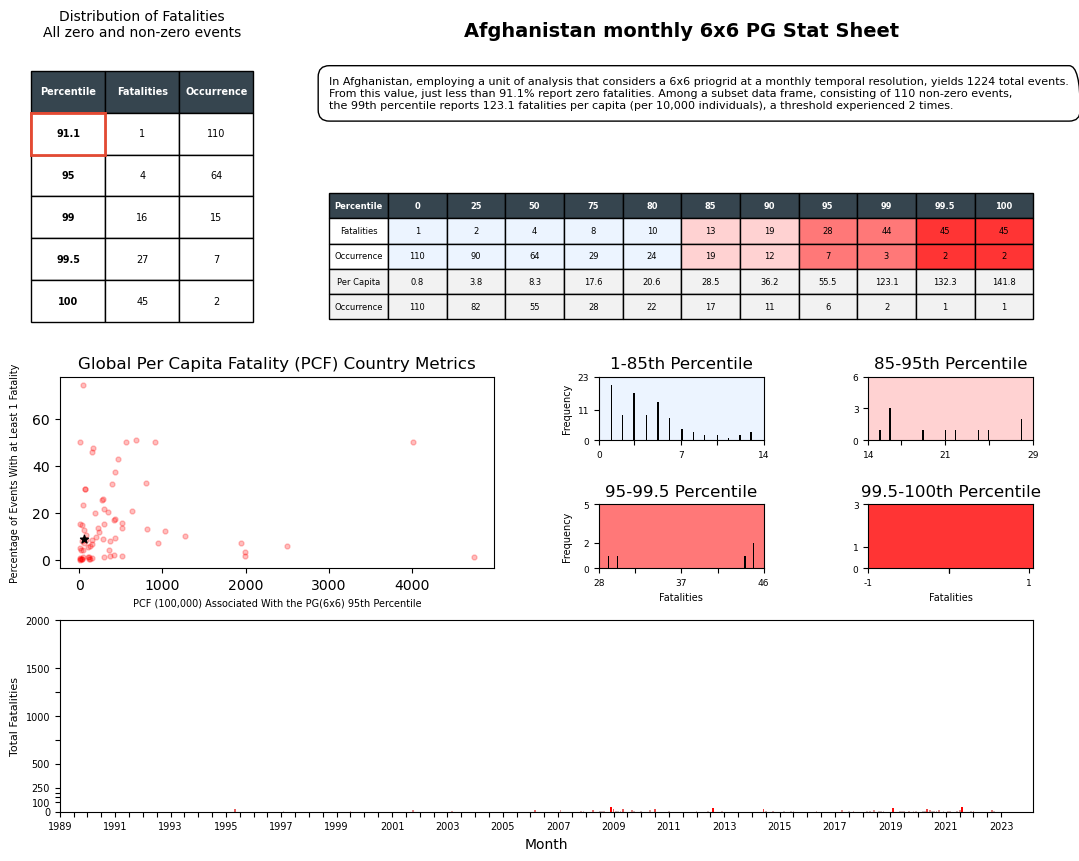

()


In [38]:
#countrylist = ['Syria', 'South Sudan', 'Yemen', 'Ethiopia', 'Nigeria', 'Rwanda', 'Senegal']
#df_cm | df_pg

CM_orPG = key_dropdown.value
temporal_resolution = time_widget.value
Country = list_dropdown1.value
S = list_dropdown2.value
rec_or_all = list_dropdown3.value
Scale = S + 'x' + S
if Scale == '0x0':
    Scale = 0

Save_timeline='no'
#for i in countrylist:
x,gis = Empowered_Pantaleon(CM_orPG, df_pg, df_cm, temporal_resolution, Scale, Country, rec_or_all)
print(x)
Save_for_timeline_generation(Save_timeline, gis, CM_orPG, temporal_resolution, Scale, Country)

